tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from /content/drive/MyDrive/best_roberta_model.pth


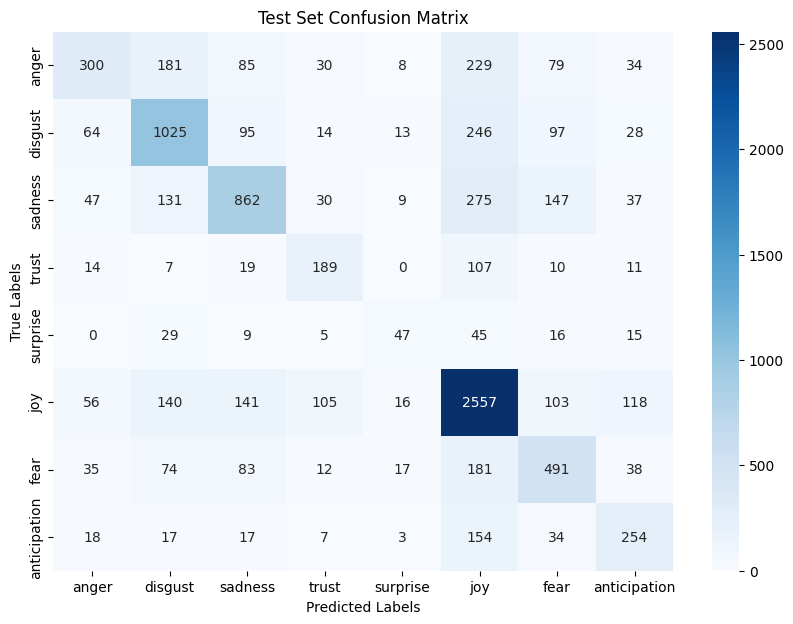

Test Set Classification Report:
              precision    recall  f1-score   support

       anger       0.56      0.32      0.41       946
     disgust       0.64      0.65      0.64      1582
     sadness       0.66      0.56      0.61      1538
       trust       0.48      0.53      0.50       357
    surprise       0.42      0.28      0.34       166
         joy       0.67      0.79      0.73      3236
        fear       0.50      0.53      0.51       931
anticipation       0.47      0.50      0.49       504

    accuracy                           0.62      9260
   macro avg       0.55      0.52      0.53      9260
weighted avg       0.61      0.62      0.61      9260



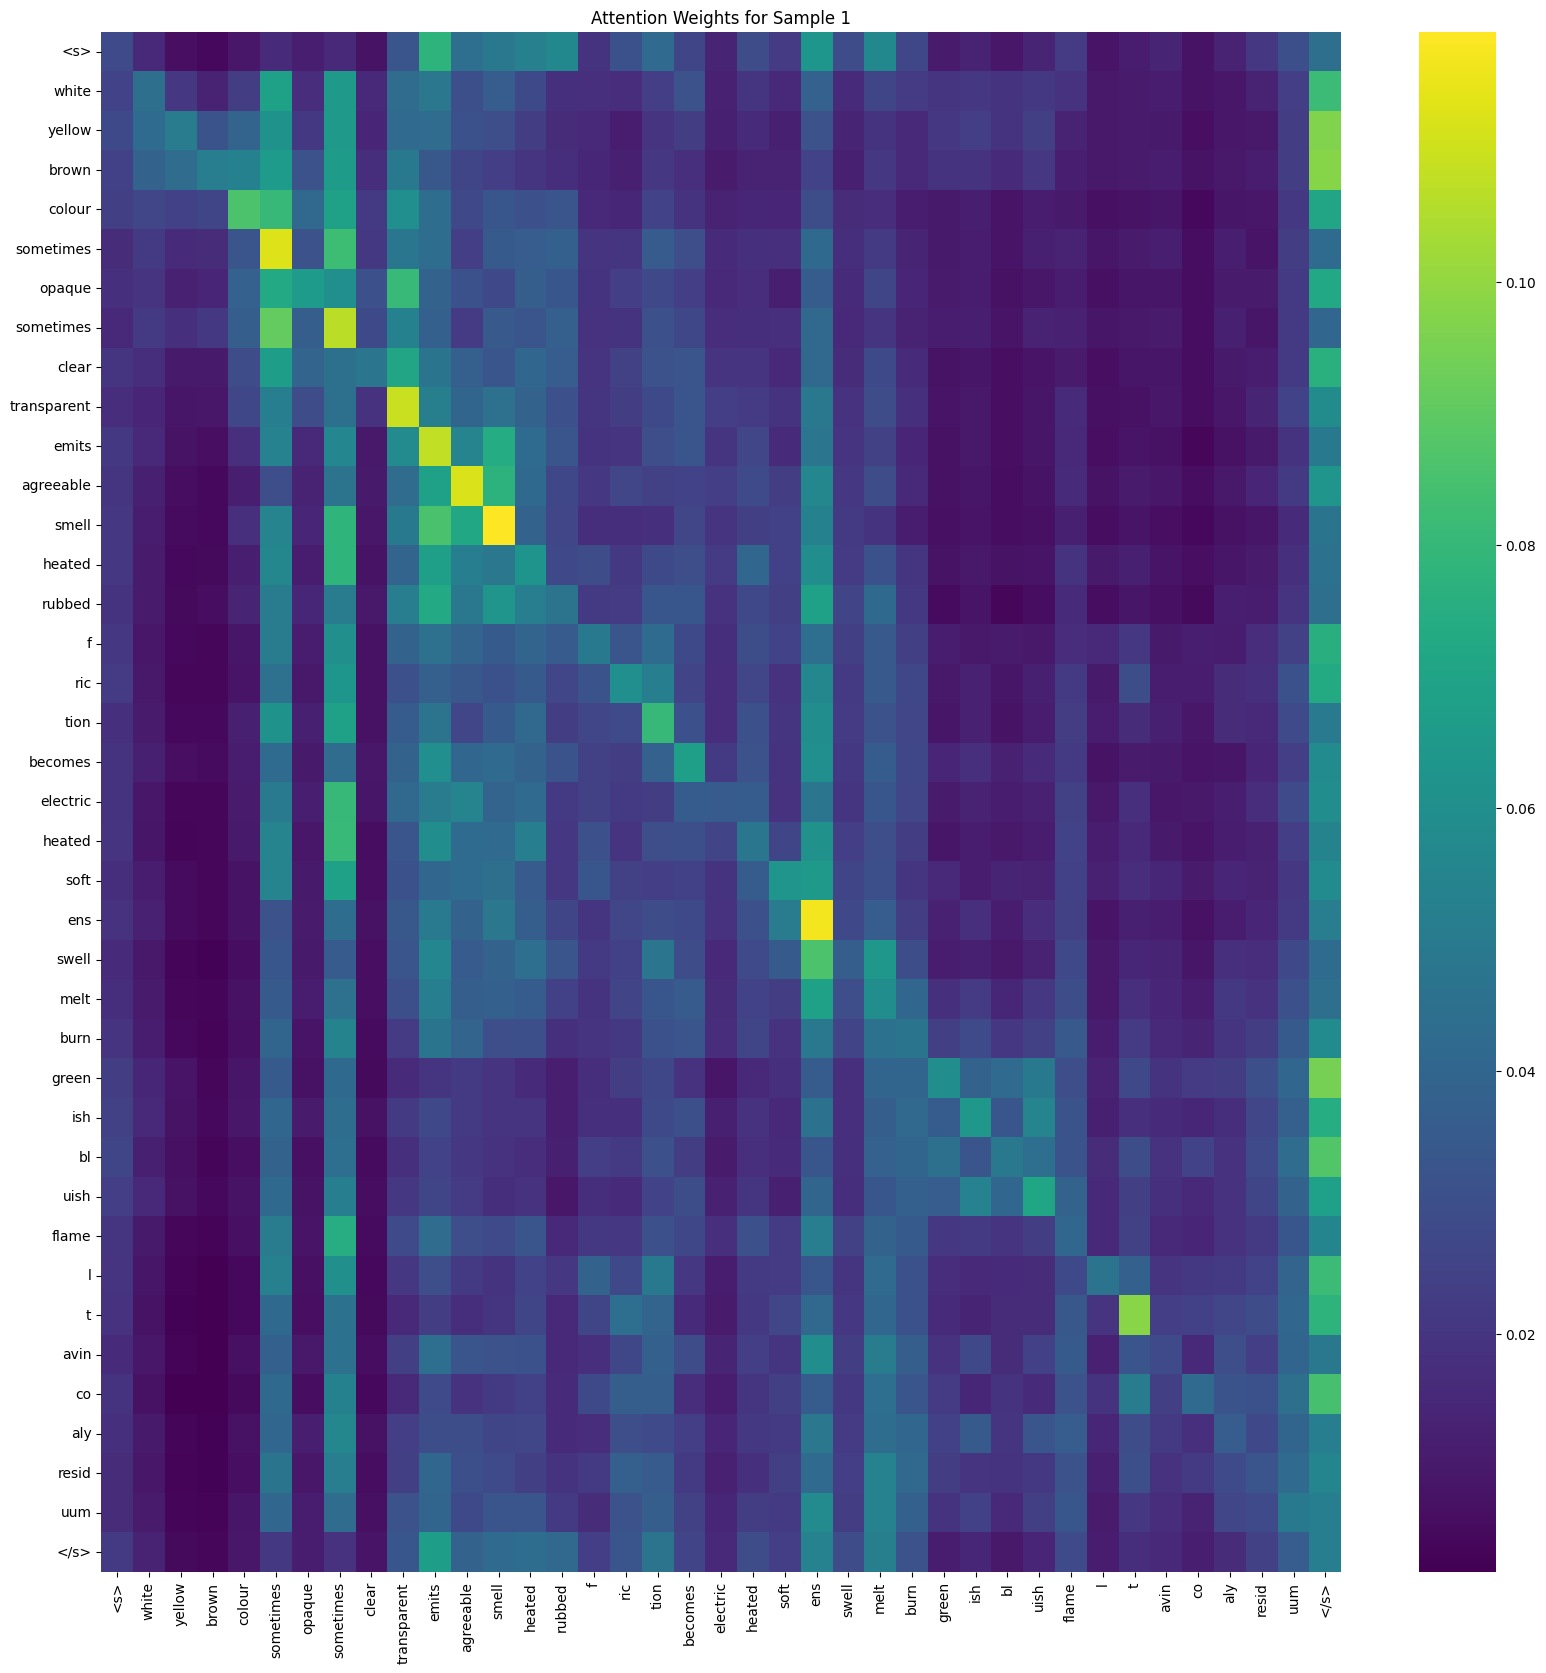

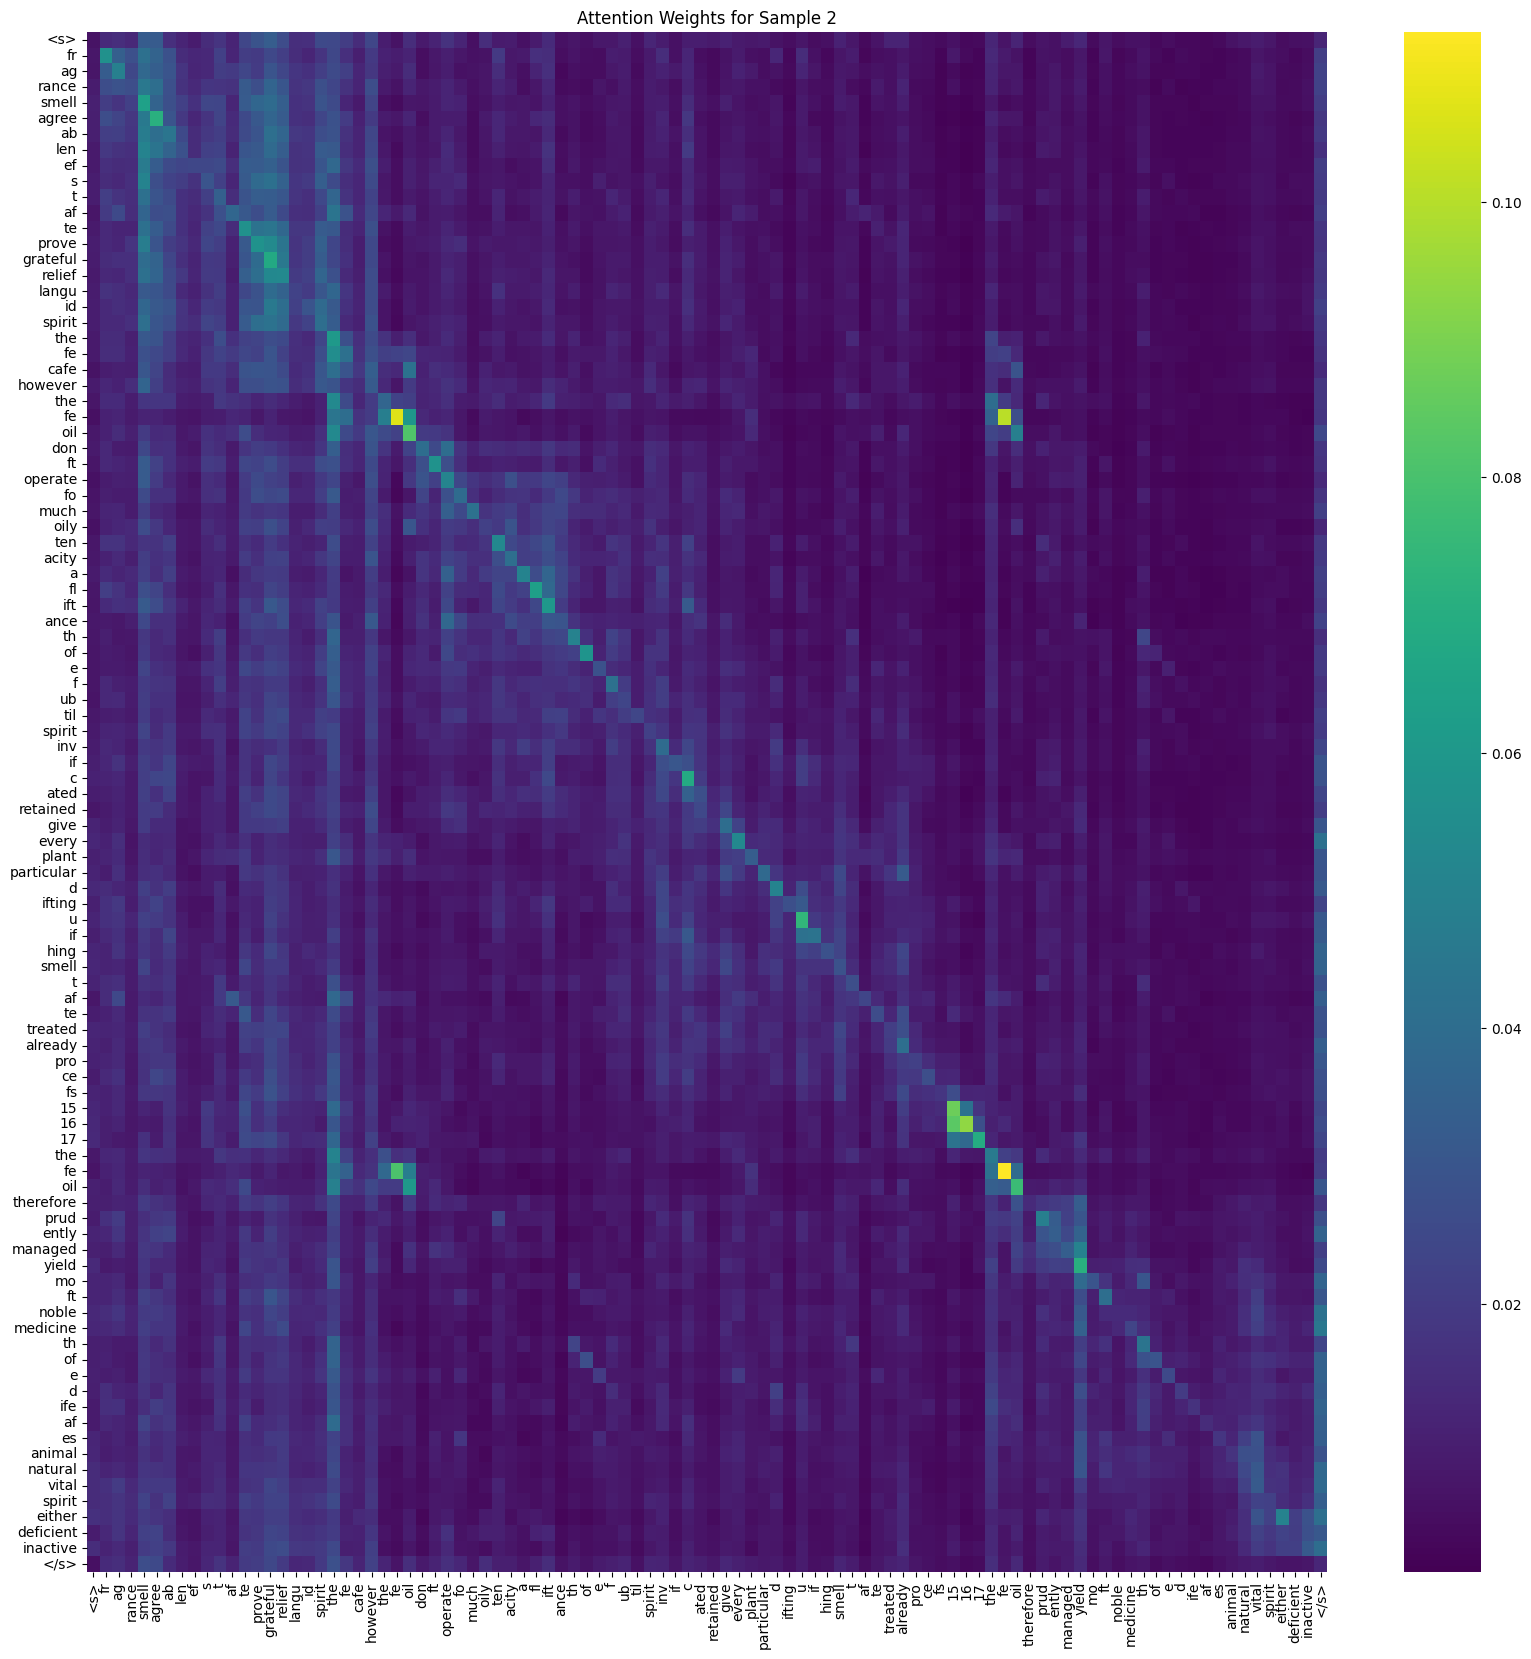

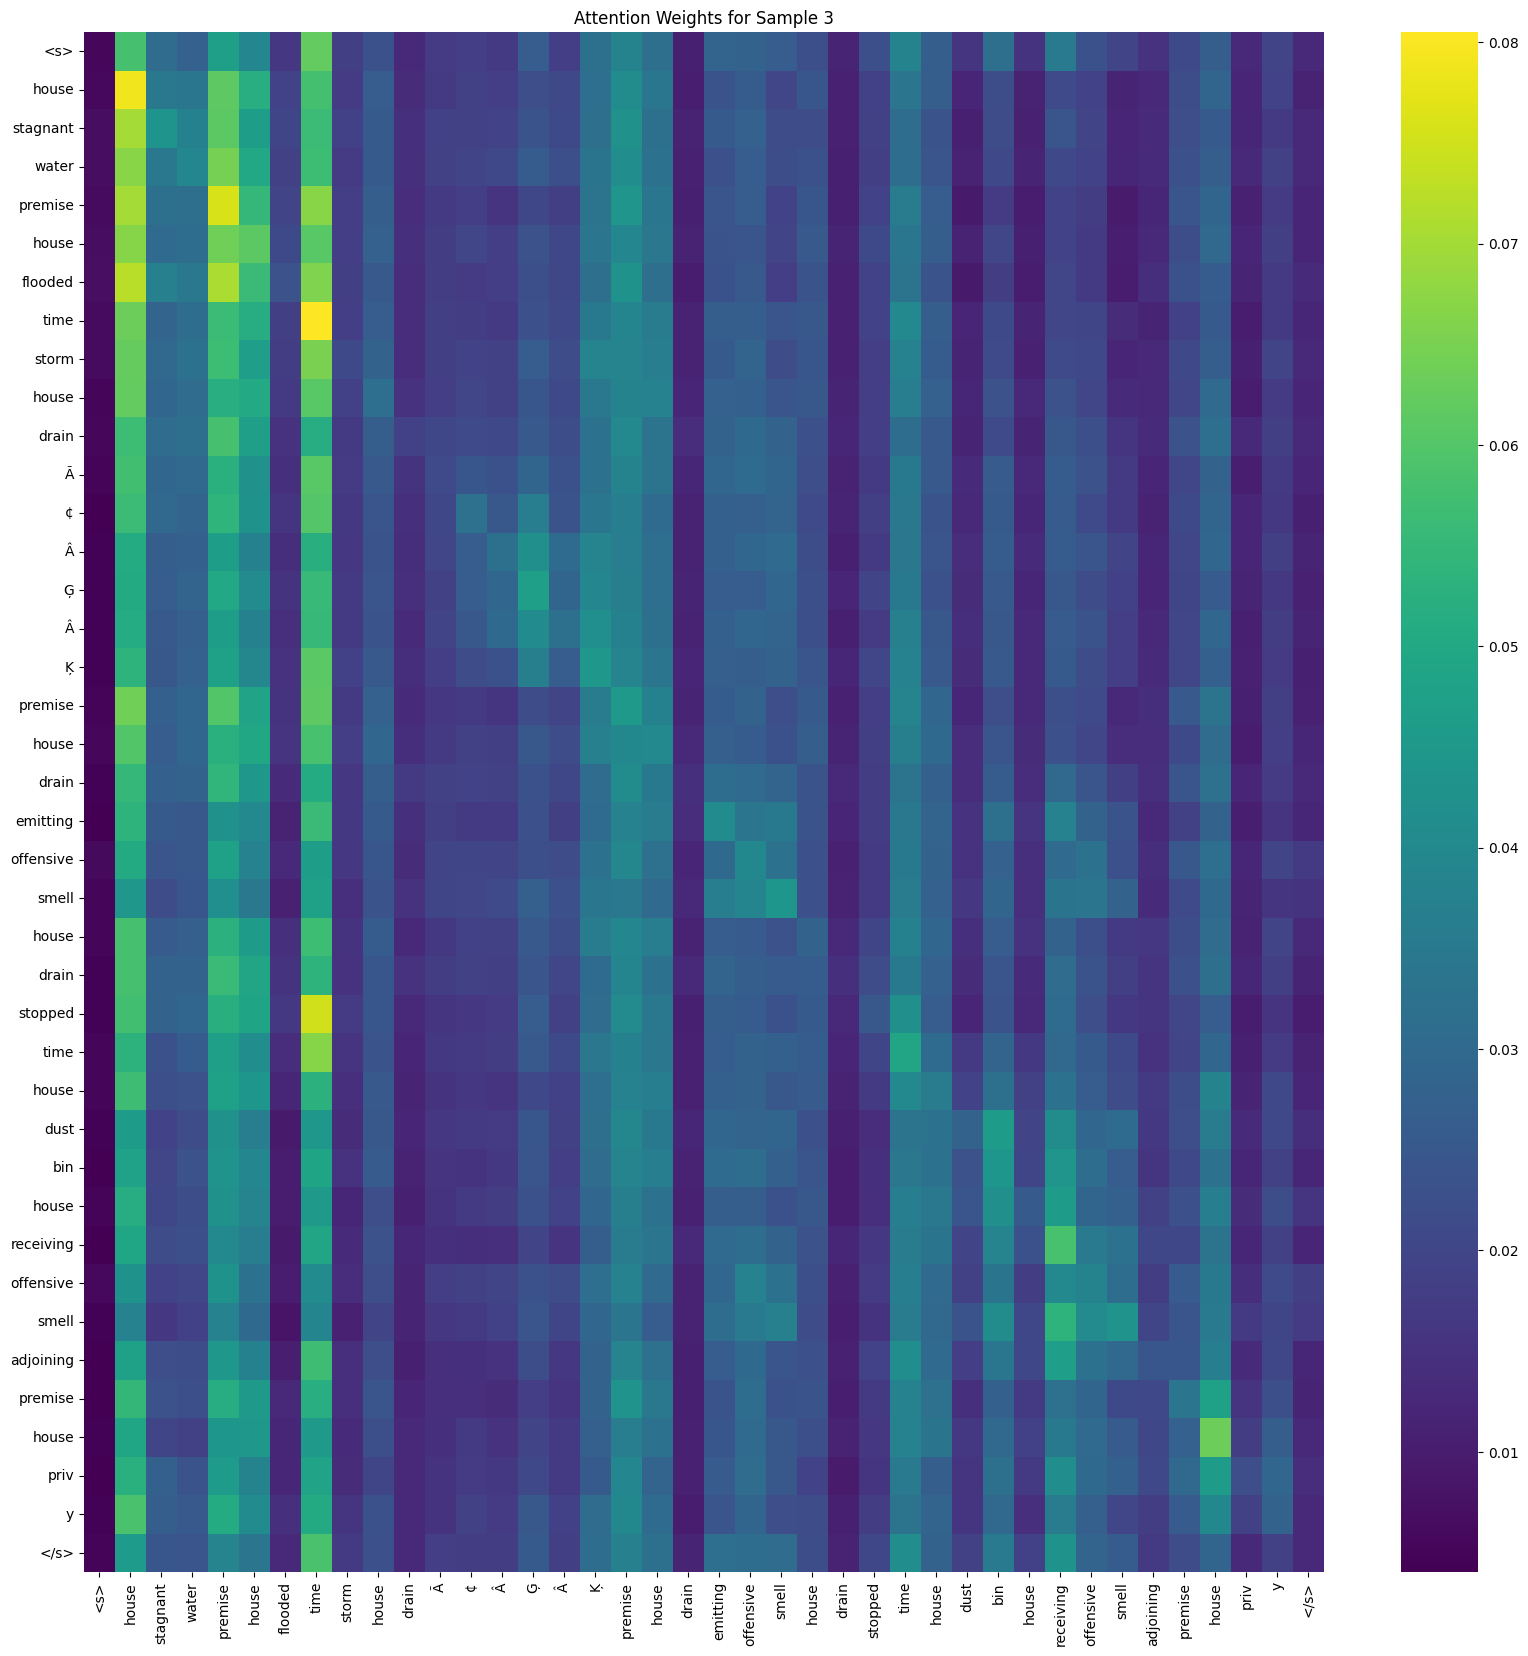

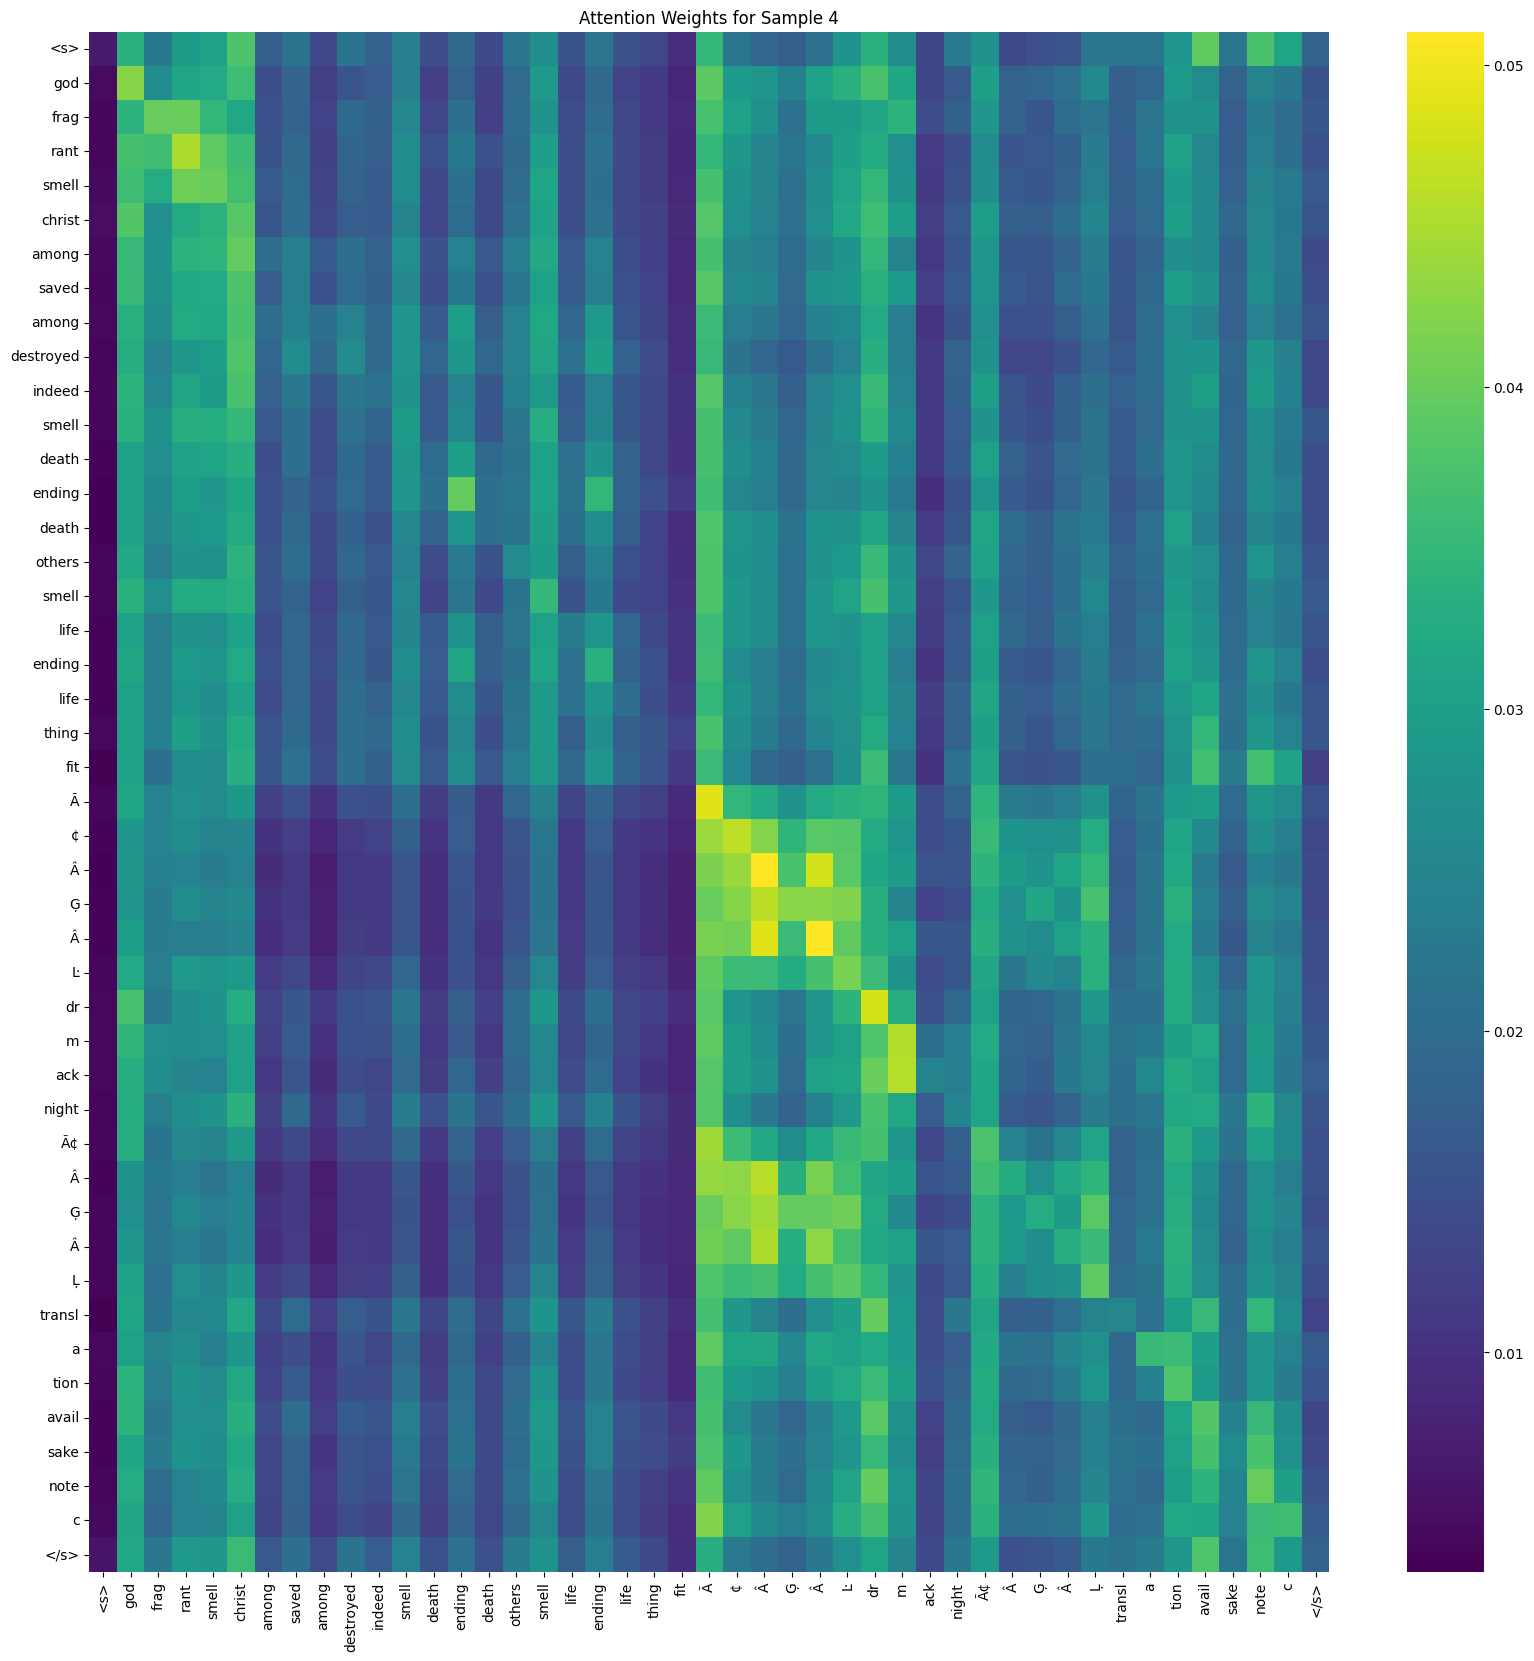

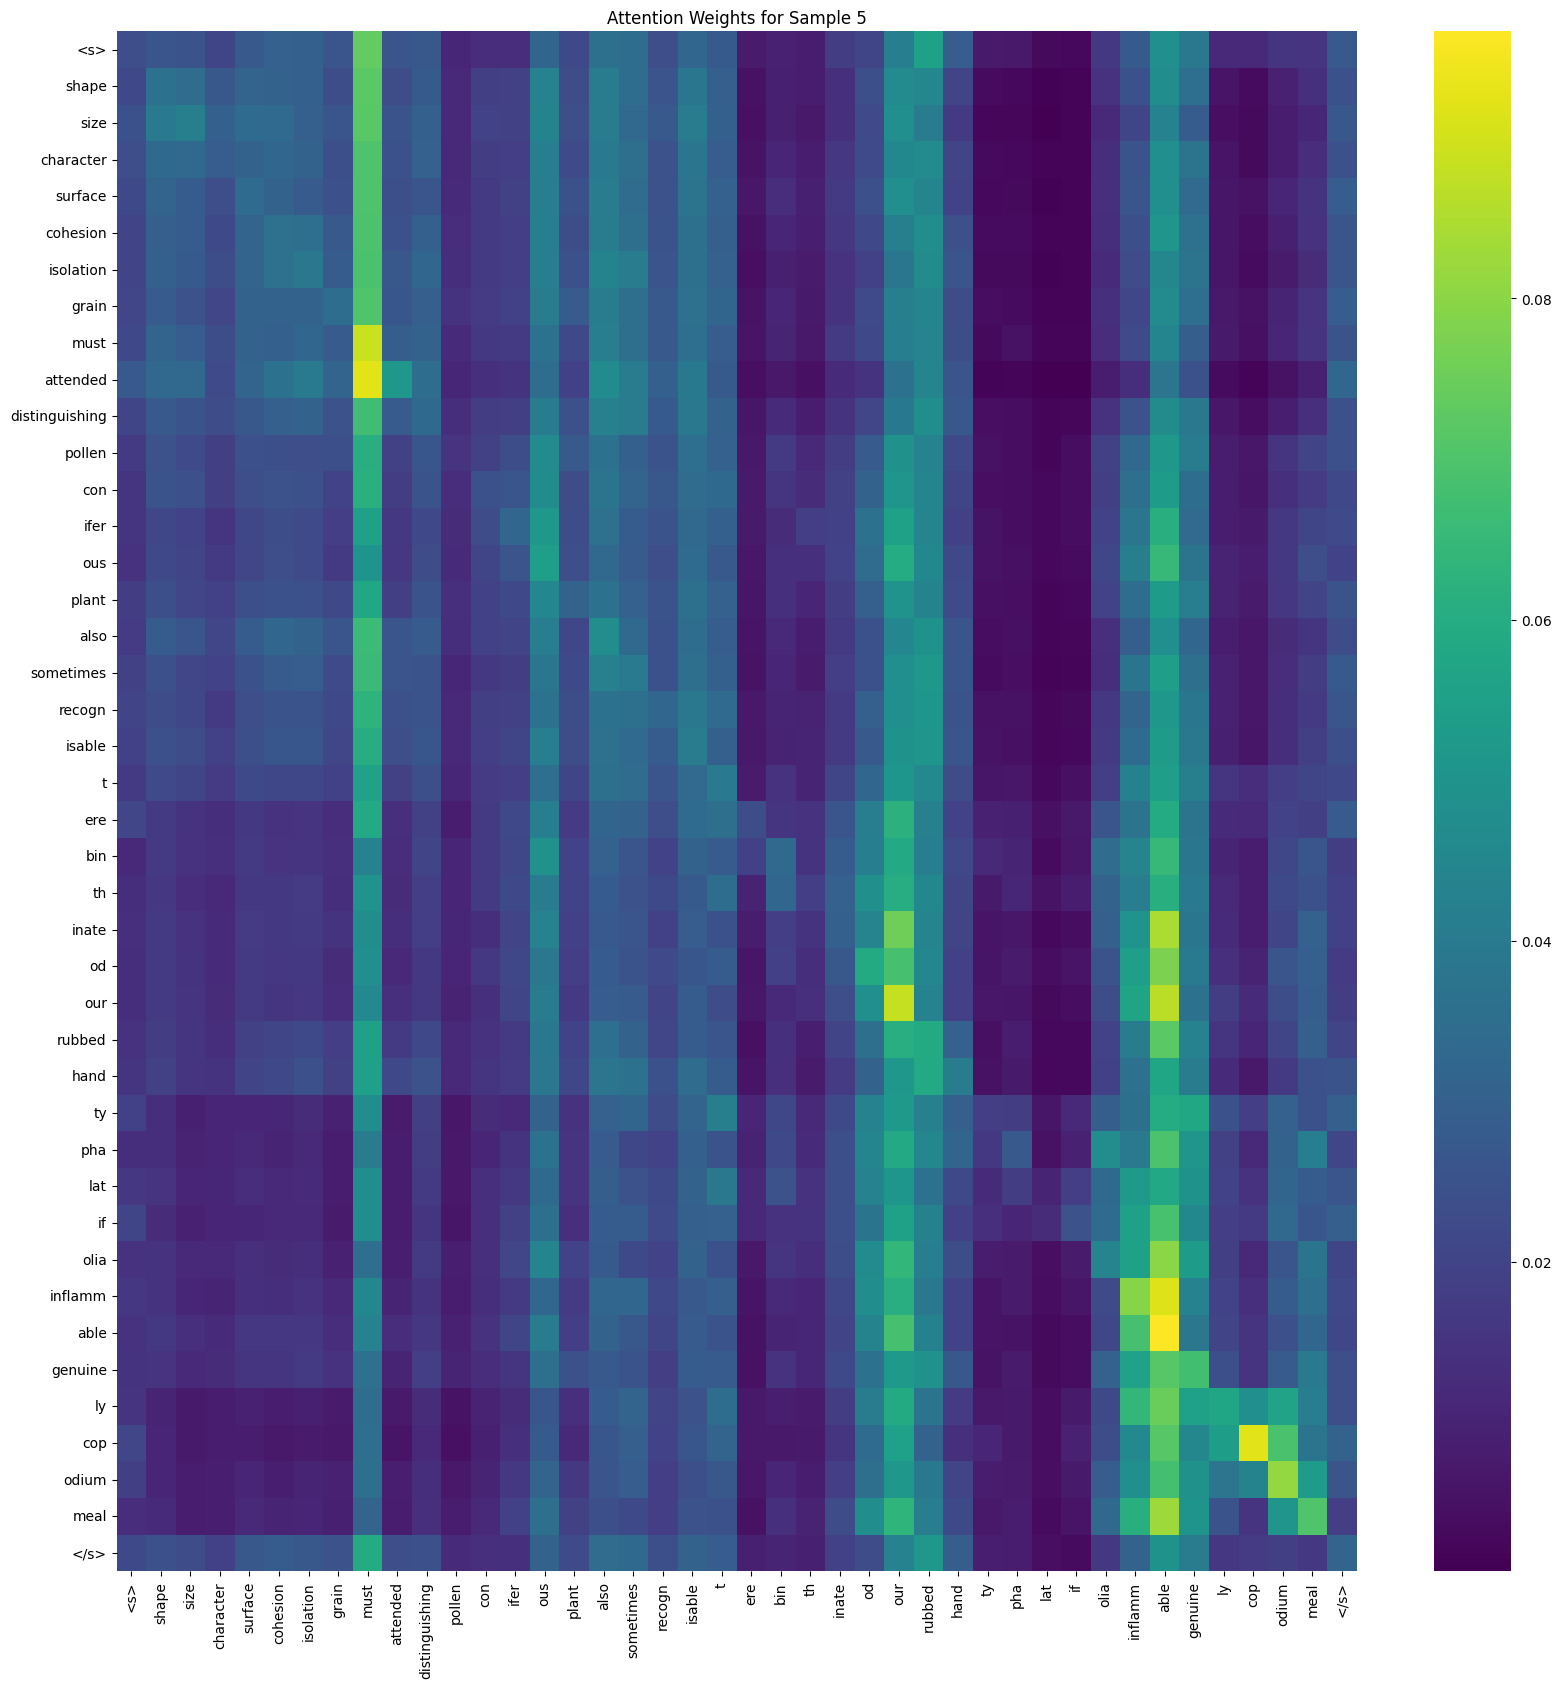

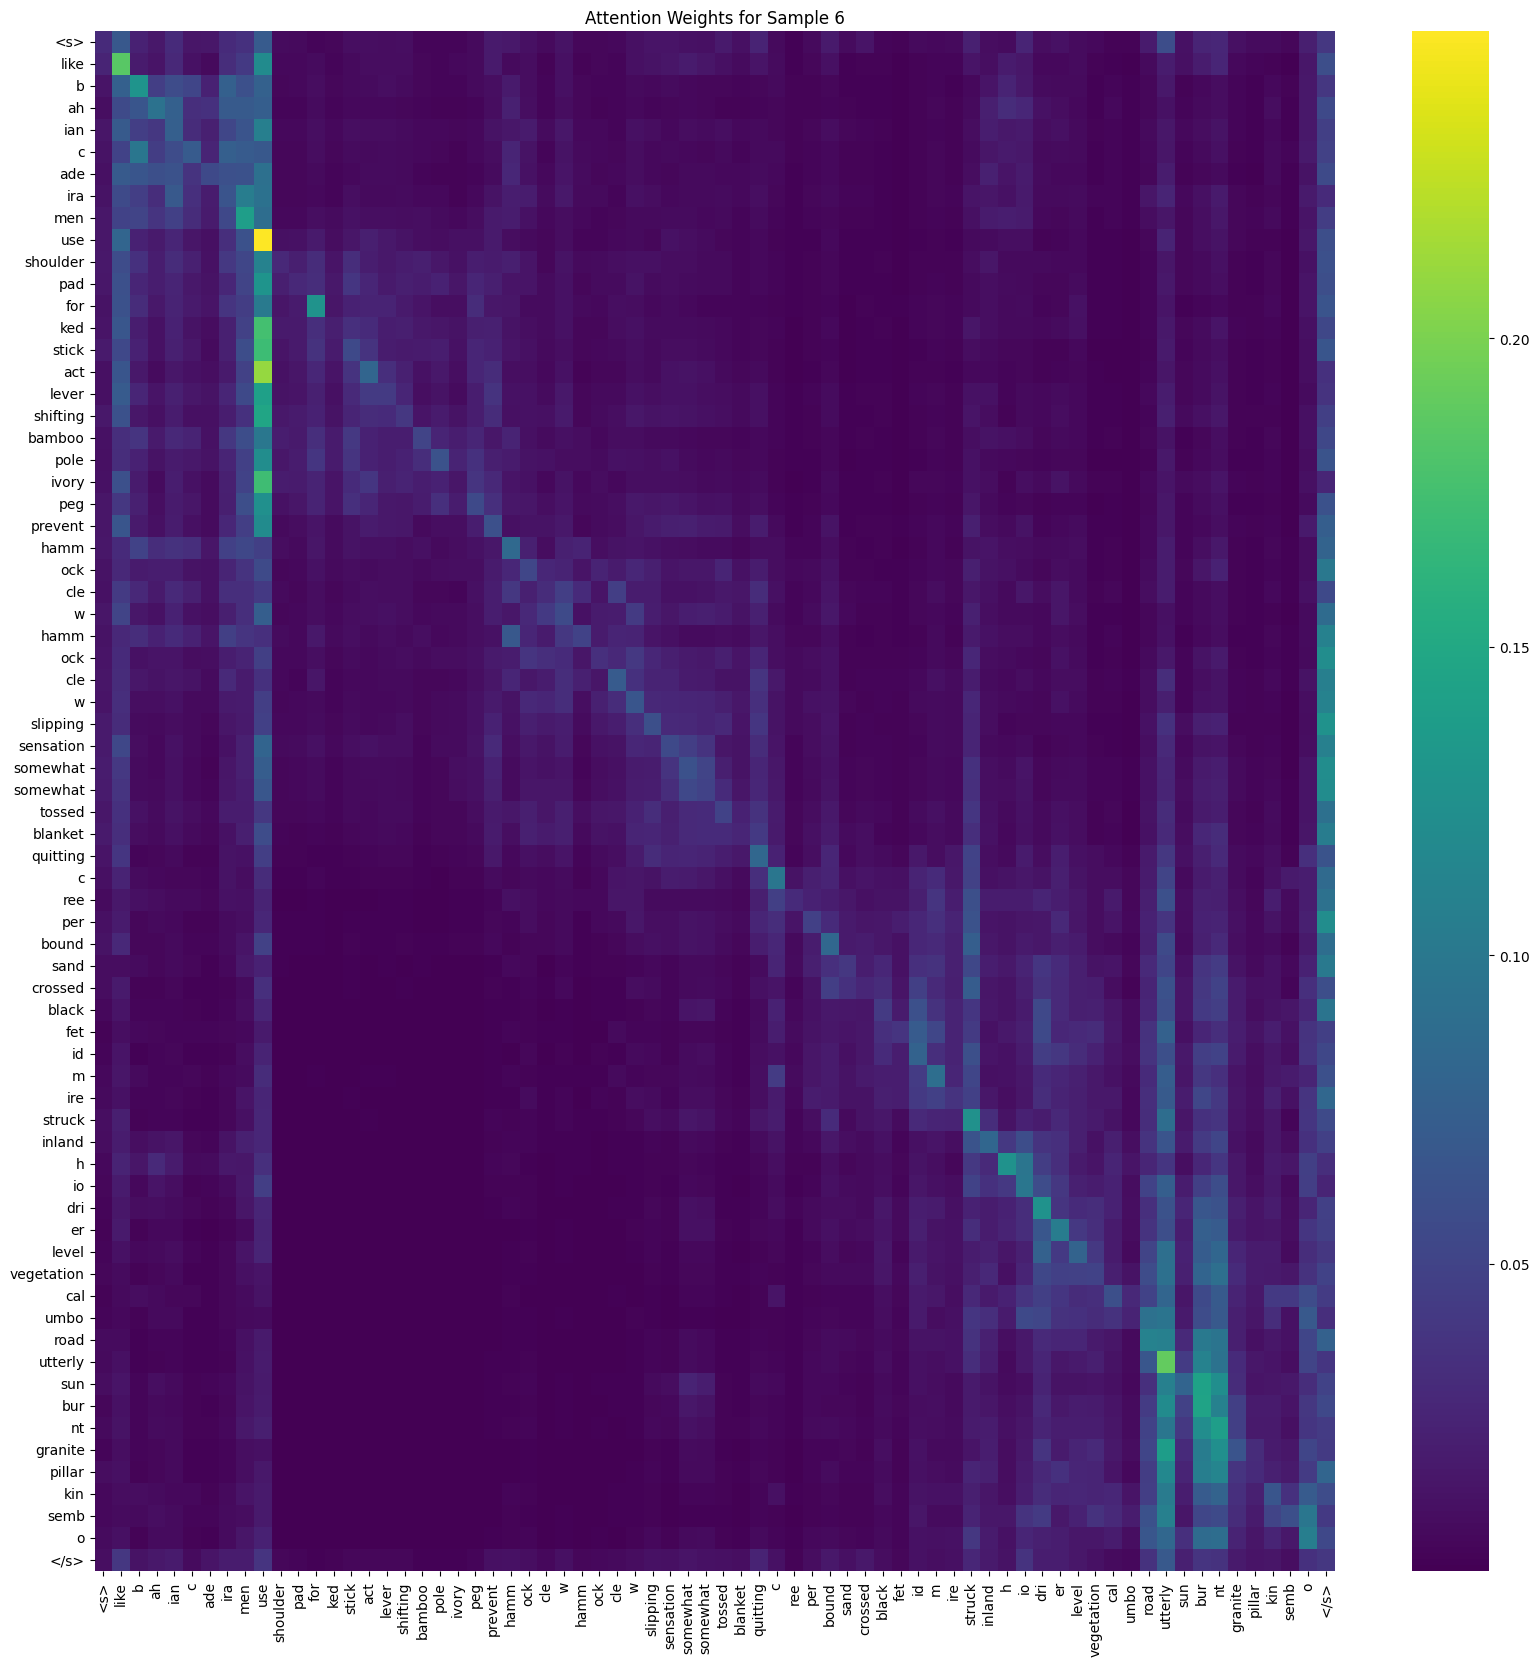

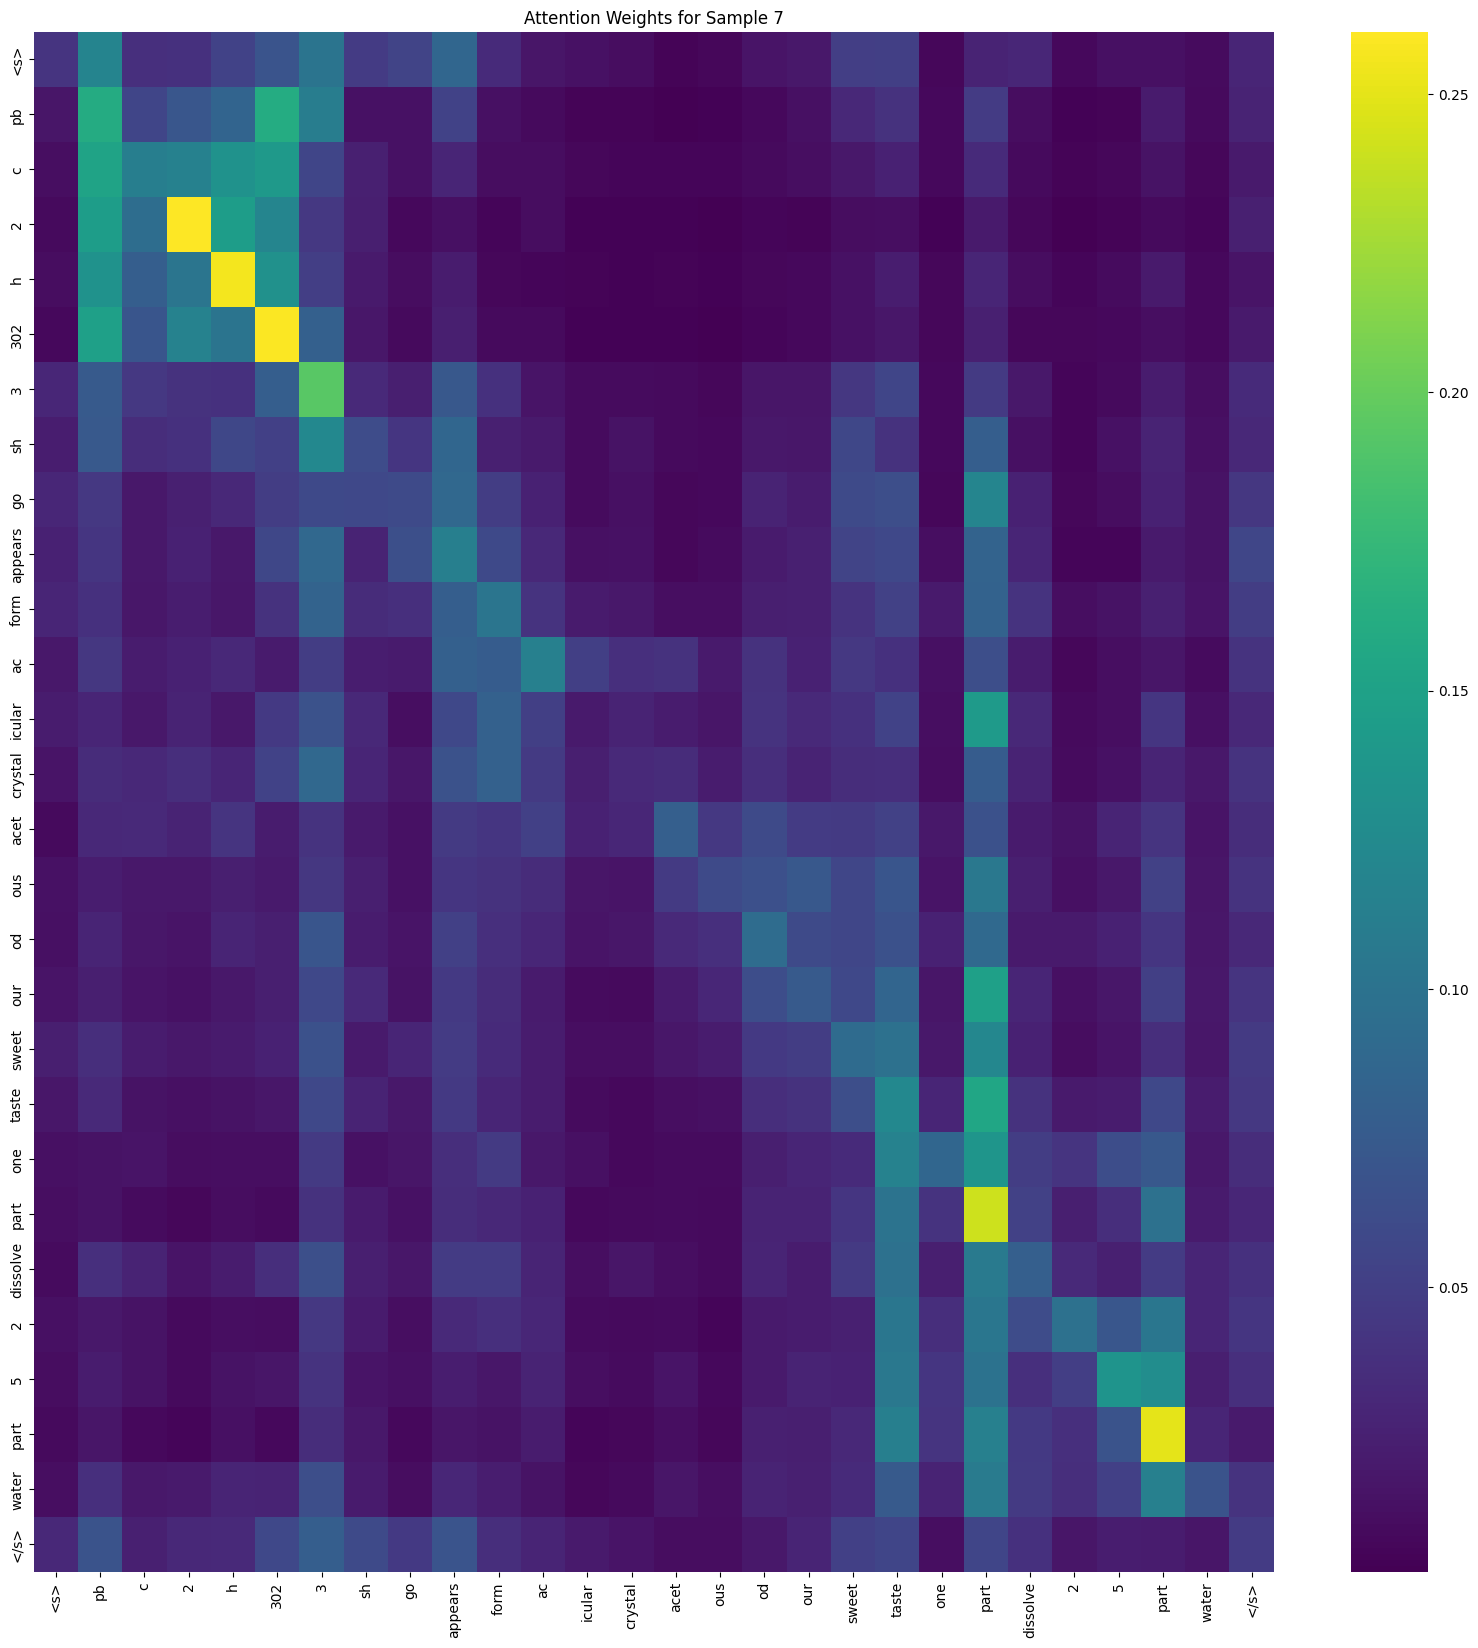

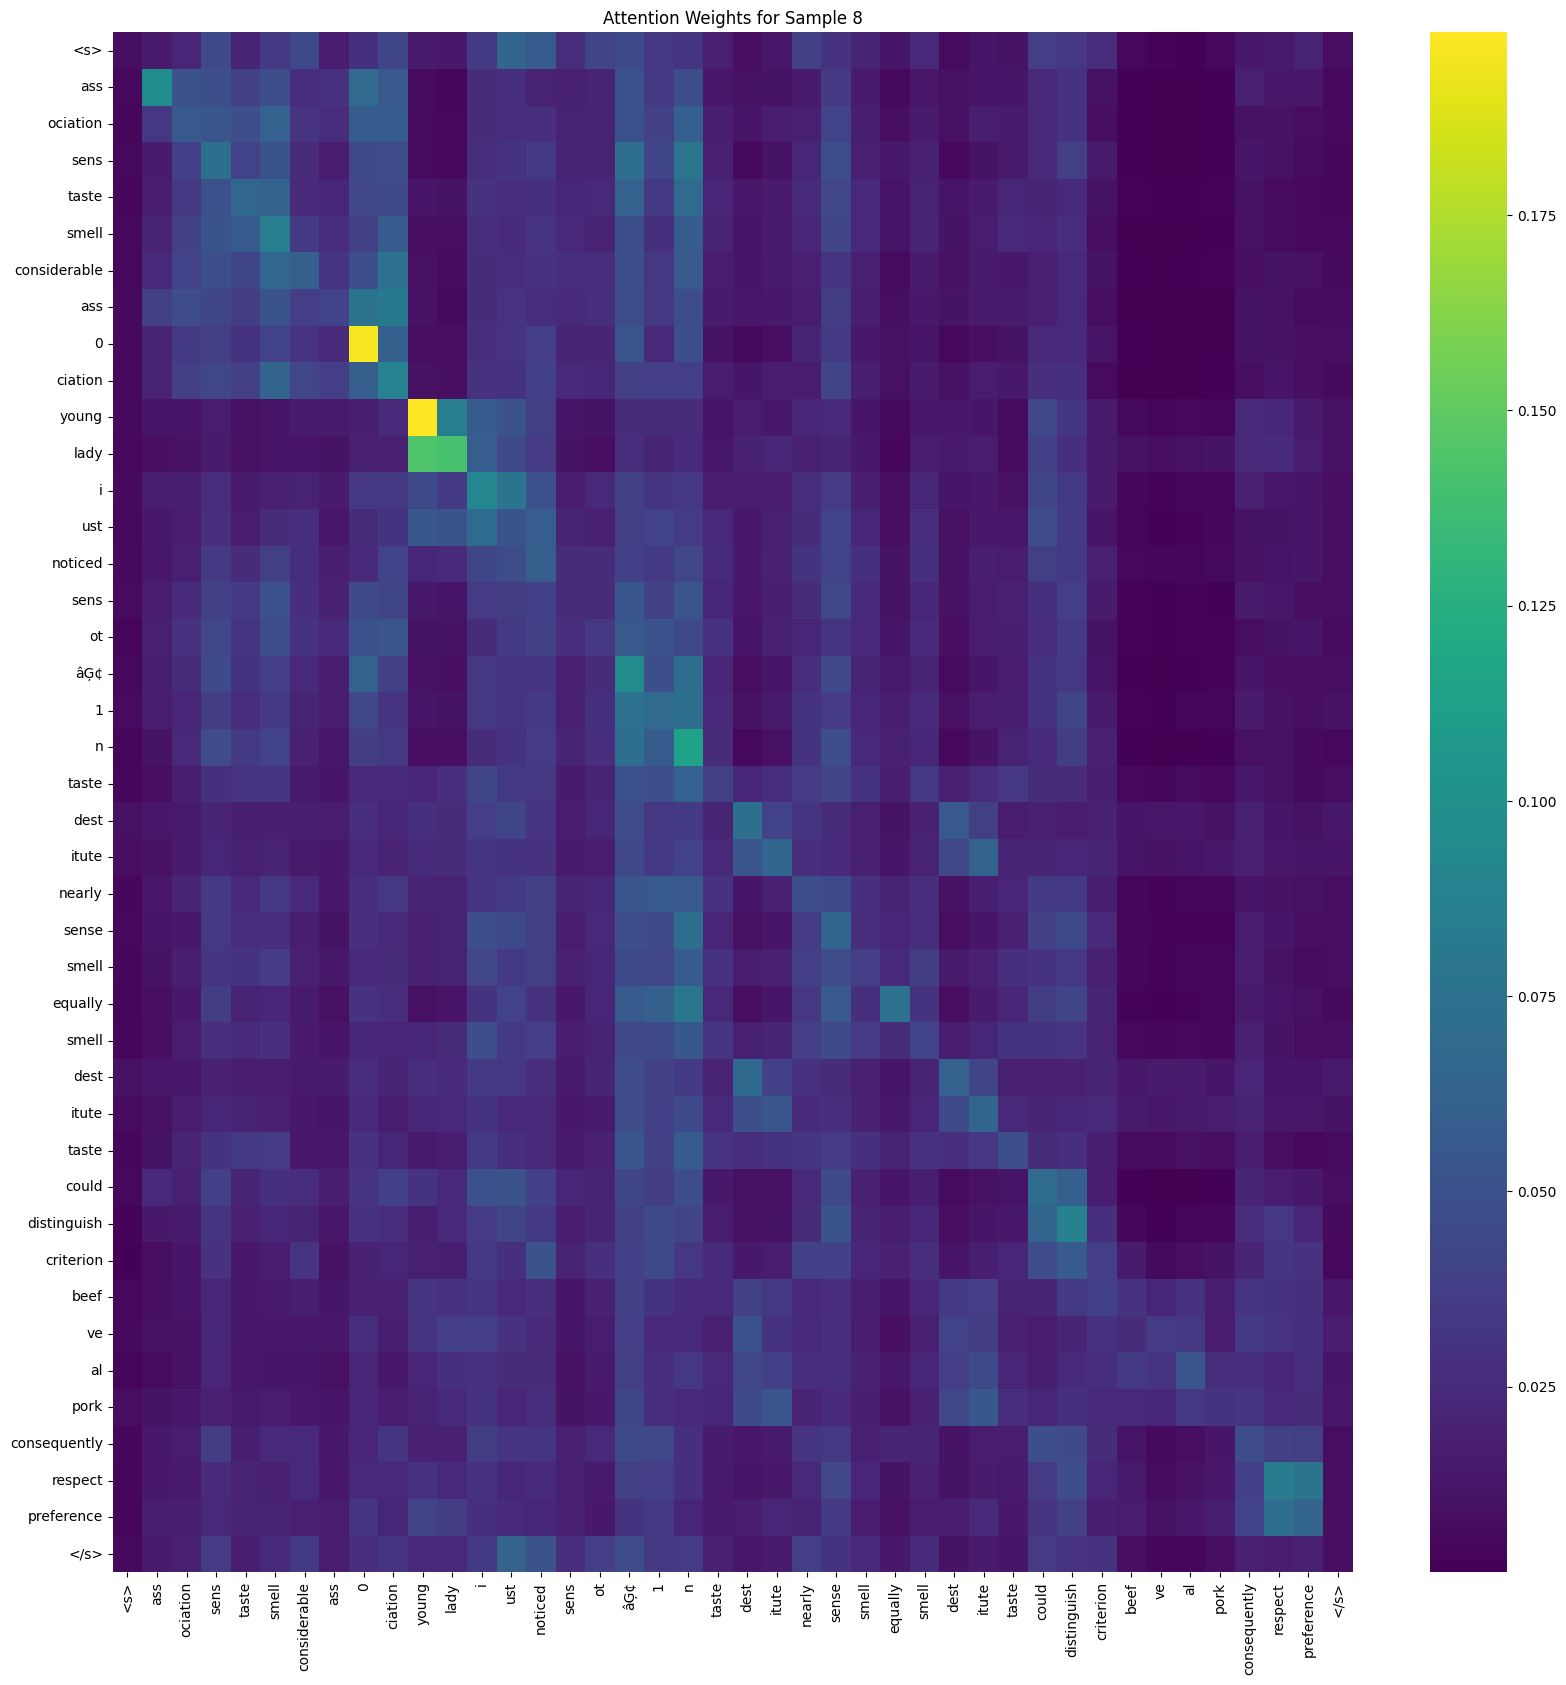

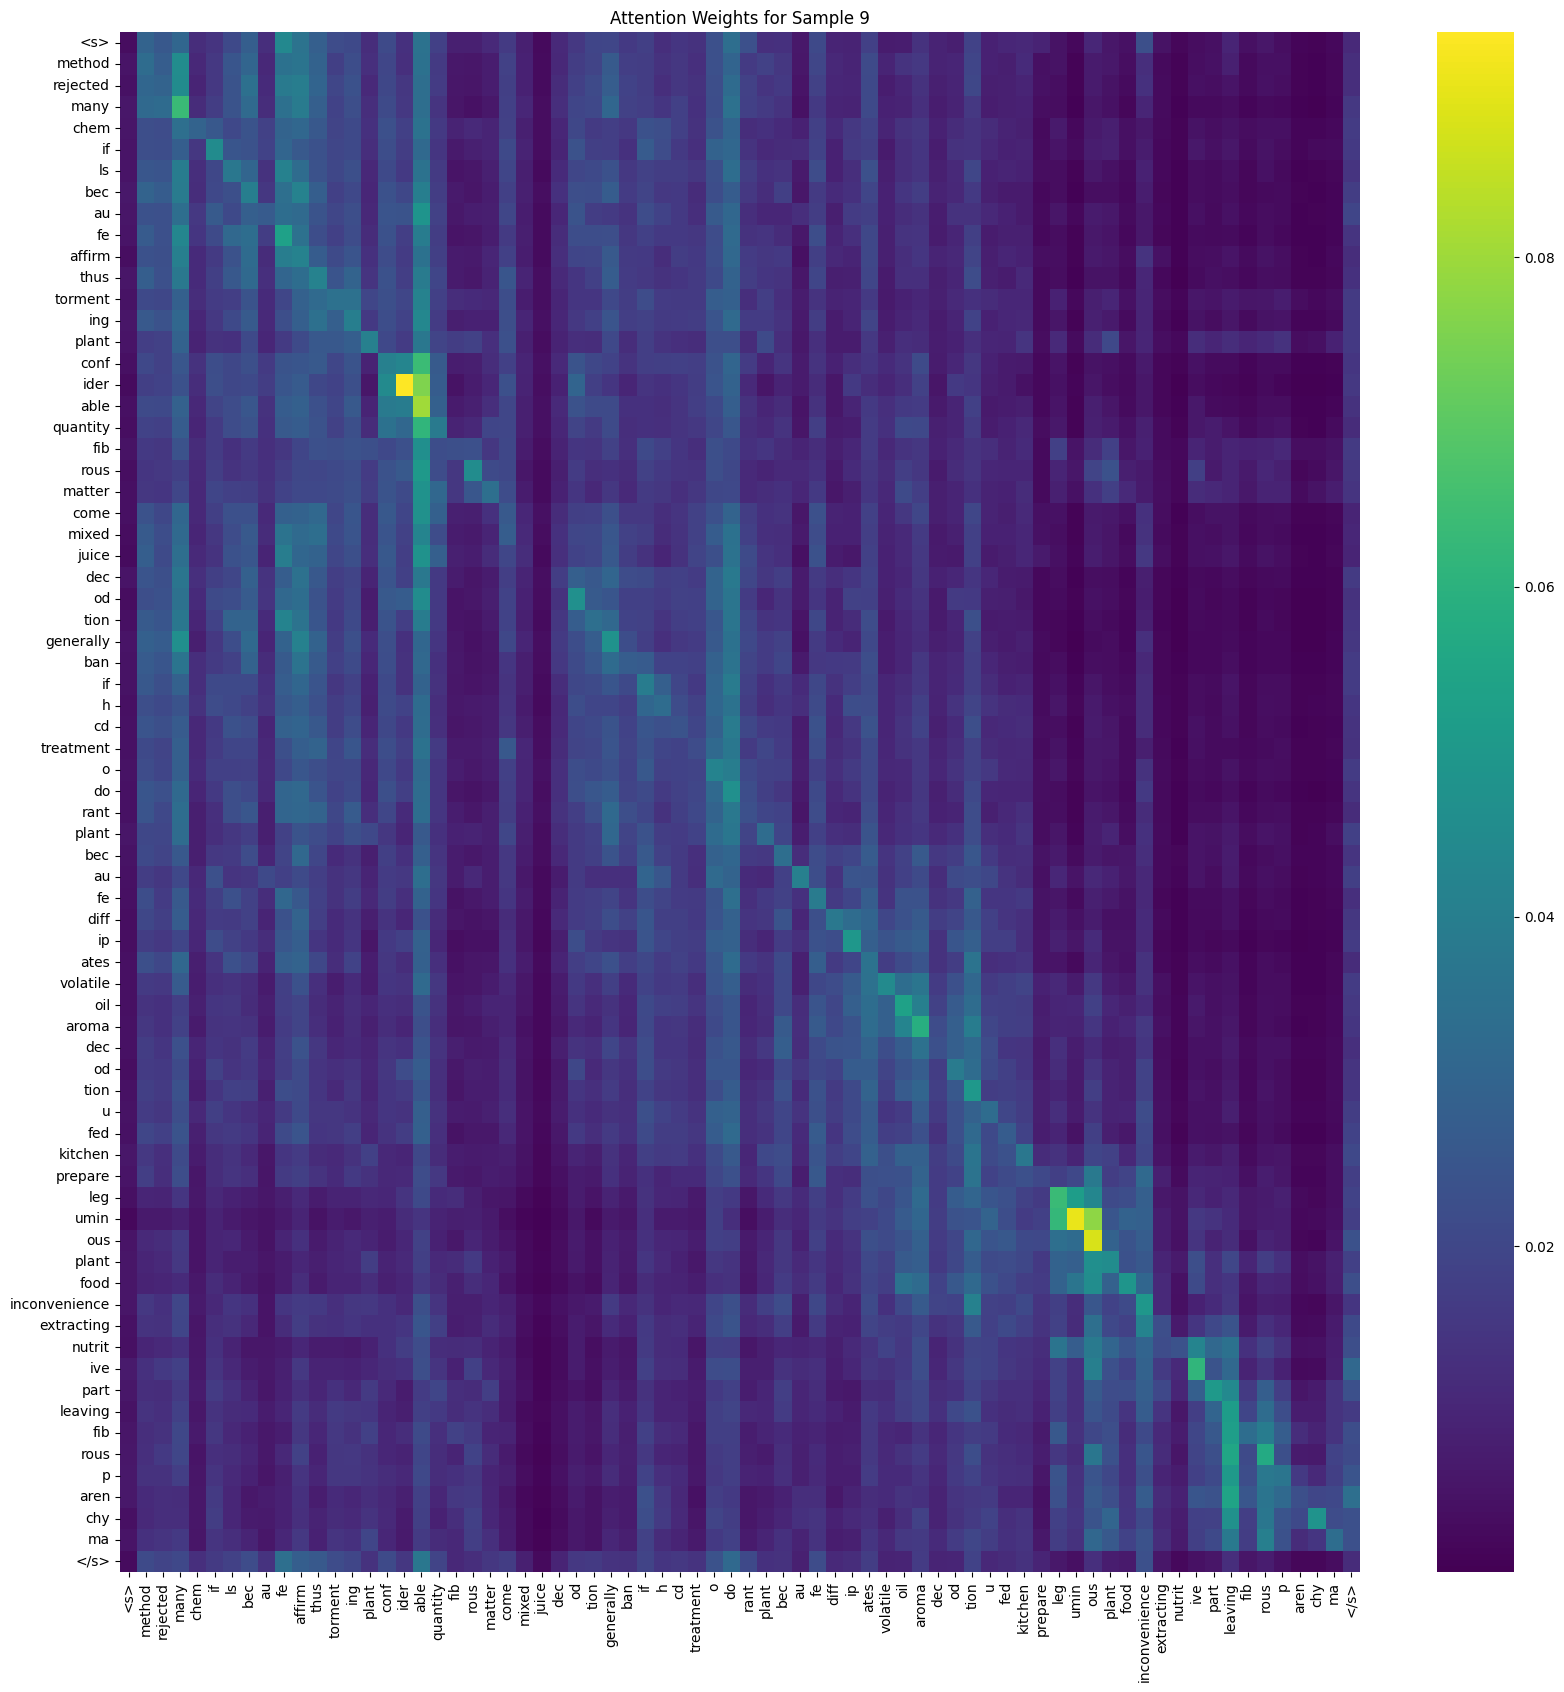

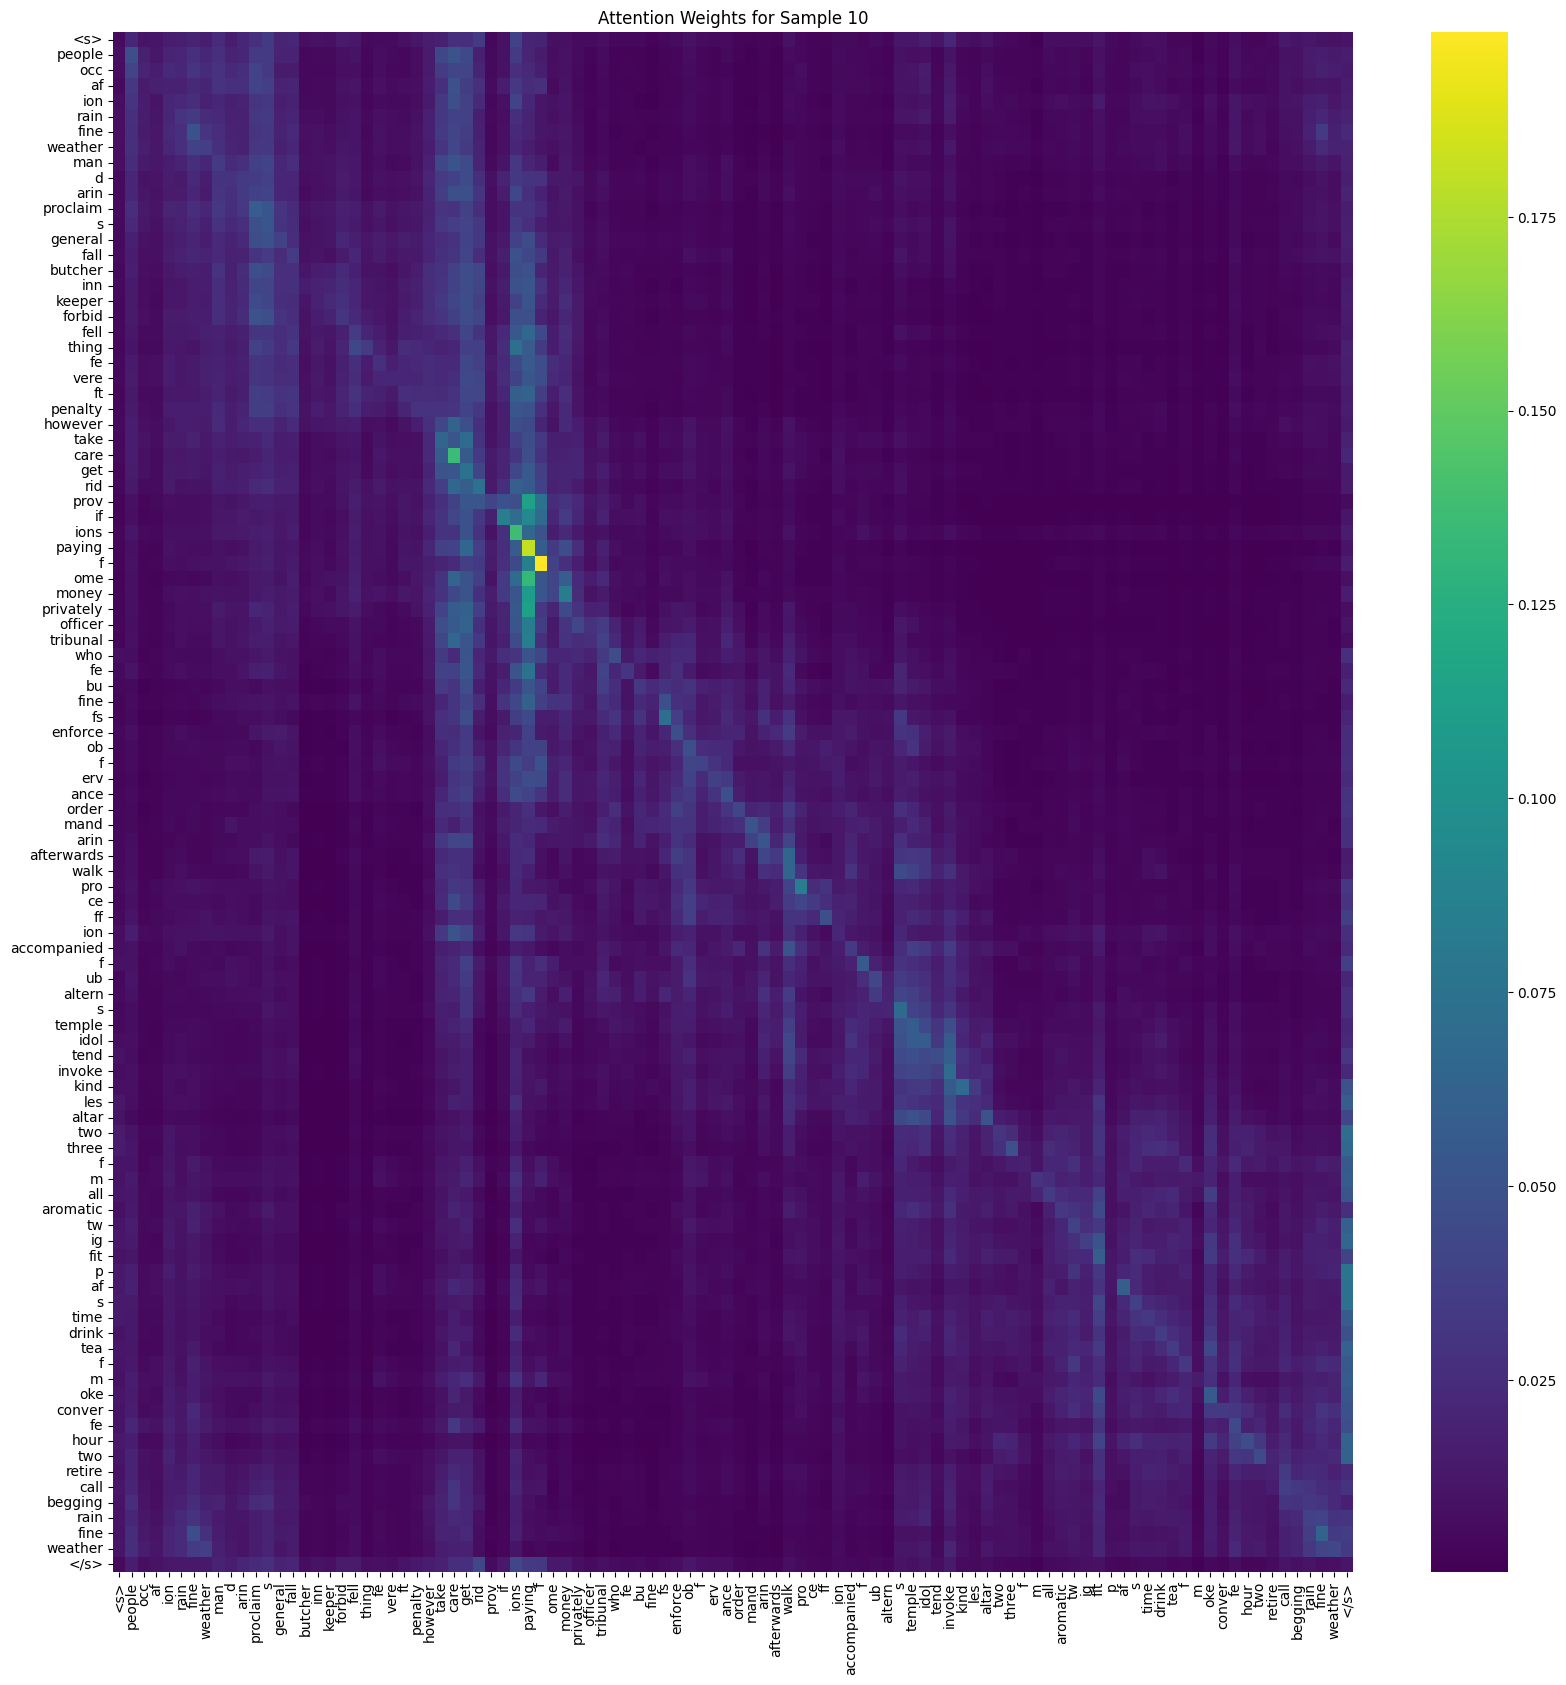

Misclassified Examples (Test Set):
Text: like bahian cadeira men use shoulder pad forked stick act lever shifting bamboo pole ivory peg prevent hammock clew hammock clew slipping sensation somewhat somewhat tossed blanket quitting creeper bound sand crossed black fetid mire struck inland hio drier level vegetation calumbo road utterly sunburnt granite pillar kinsembo
True Label: fear, Predicted Label: sadness

Text: pb c2h302 3 shgo appears form acicular crystal acetous odour sweet taste one part dissolve 2 5 part water
True Label: disgust, Predicted Label: joy

Text: method rejected many chemifls becaufe affirm thus tormenting plant confiderable quantity fibrous matter come mixed juice decodtion generally banifhcd treatment odo rant plant becaufe diffipates volatile oil aroma decodtion ufed kitchen prepare leguminous plant food inconvenience extracting nutritive part leaving fibrous parenchyma
True Label: disgust, Predicted Label: sadness

Text: constituent tobacco albumen resin extra

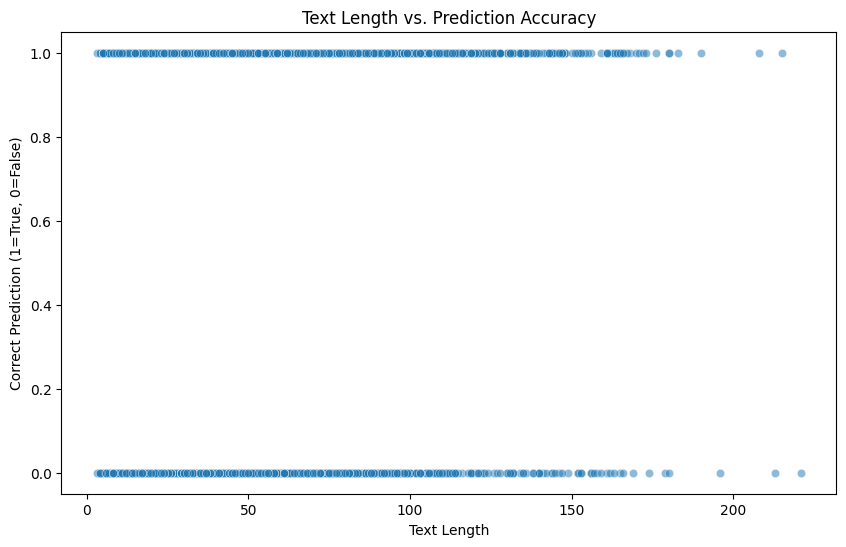

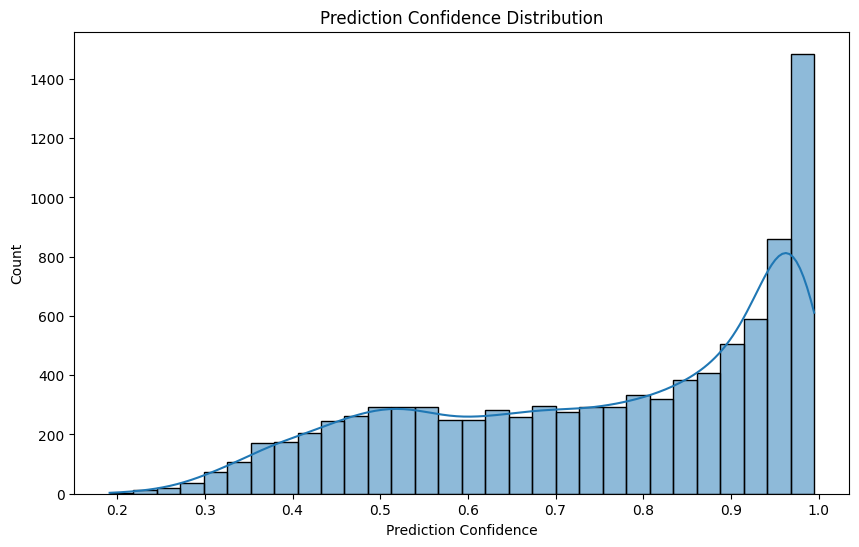

Feature Importance Scores (Permutation Method):
Text: white yellow brown colour sometimes opaque sometimes clear transparent emits agreeable smell heated rubbed fric tion becomes electric heated softens swell melt burn greenish bluish flame ltavin coaly residuum
Score: 0.7241379310344828

Text: fragrance smell agreeablenefs tafte prove grateful relief languid spirit thefe cafe however thefe oil donft operate fo much oily tenacity afliftance thofe fubtil spirit invifcated retained give every plant particular diftinguifhing smell tafte treated already procefs 15 16 17 thefe oil therefore prudently managed yield moft noble medicine thofe difeafes animal natural vital spirit either deficient inactive
Score: 0.9649122807017544

Text: house stagnant water premise house flooded time storm house drain â   premise house drain emitting offensive smell house drain stopped time house dust bin house receiving offensive smell adjoining premise house privy
Score: 0.9705882352941176

Text: god fragr

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters
MAX_LEN = 256
BATCH_SIZE = 64
TEST_SIZE = 0.15
VALIDATE_SIZE = 0.1765
RANDOM_STATE_INT = 14988828

# Load data
df = pd.read_csv('/content/drive/MyDrive/english_only.csv')

# Define dataset class
class EmotionDataset(Dataset):
    def __init__(self, excerpts, labels, tokenizer, max_len):
        self.excerpts = excerpts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.excerpts)

    def __getitem__(self, idx):
        text = str(self.excerpts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenizer and Model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Enable attention outputs
config = RobertaConfig.from_pretrained('roberta-base', output_attentions=True)
config.num_labels = len(df['plutchik_emotion'].unique())
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

# Map emotions to integers
label_dict = {label: idx for idx, label in enumerate(df['plutchik_emotion'].unique())}
df['emotion_labels'] = df['plutchik_emotion'].replace(label_dict)

# Data splits
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['excerpt_value_cleaned'],
    df['emotion_labels'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE_INT,
    stratify=df['emotion_labels']
)

# Reset index
test_texts = test_texts.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create dataset and data loader
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load the model
model_path = '/content/drive/MyDrive/best_roberta_model.pth'
model.load_state_dict(torch.load(model_path))
model.to('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model loaded from {model_path}")

def evaluate(loader, set_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_texts = []
    attention_weights = []
    all_confidences = []
    misclassified_examples = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            confidences = torch.softmax(logits, dim=-1).max(dim=-1).values

            all_predictions.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_texts.extend(input_ids.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

            # Collect misclassified examples
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_examples.append({
                        'text': tokenizer.decode(input_ids[i], skip_special_tokens=True),
                        'true_label': [k for k, v in label_dict.items() if v == labels[i].item()][0],  # Get the emotion label
                        'predicted_label': [k for k, v in label_dict.items() if v == preds[i].item()][0]  # Get the emotion label
                    })

            # Collect attention weights and average over all heads
            if outputs.attentions:
                attention = outputs.attentions[-1].mean(dim=1).cpu().numpy()
                attention_weights.extend(attention)

    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    # Plotting the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    plt.title(f'{set_name} Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Print classification report
    labels_expected = list(range(len(label_dict)))
    target_names = [label for label, index in sorted(label_dict.items(), key=lambda x: x[1])]
    report = classification_report(all_true_labels, all_predictions, target_names=target_names, zero_division=1)
    print(f"{set_name} Set Classification Report:")
    print(report)
    # Save the report
    with open(f'/content/drive/MyDrive/results/roberta_{set_name}_classification_report.txt', 'w') as file:
        file.write(report)

    # Attention visualization for a few samples
    num_samples = min(10, len(all_texts))  # Visualize attention for 5 samples or less if dataset is small
    for i in range(num_samples):
        text_ids = all_texts[i]
        tokens = tokenizer.convert_ids_to_tokens(text_ids)

        # Remove padding tokens and handle special characters correctly
        tokens = [token.replace("Ġ", "") for token in tokens if token != tokenizer.pad_token]
        attention = attention_weights[i][:len(tokens), :len(tokens)]

        # Plot attention weights
        plt.figure(figsize=(20, 20))
        sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
        plt.title(f'Attention Weights for Sample {i+1}')
        plt.show()

    # Misclassified examples
    print(f"Misclassified Examples ({set_name} Set):")
    for example in misclassified_examples[:30]:  # Show only the first 10 misclassified examples
        print(f"Text: {example['text']}")
        print(f"True Label: {example['true_label']}, Predicted Label: {example['predicted_label']}")
        print("")

    # Text length analysis
    text_lengths = [len(tokenizer.decode(ids, skip_special_tokens=True).split()) for ids in all_texts]
    correct_predictions = [1 if p == t else 0 for p, t in zip(all_predictions, all_true_labels)]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=text_lengths, y=correct_predictions, alpha=0.5)
    plt.xlabel('Text Length')
    plt.ylabel('Correct Prediction (1=True, 0=False)')
    plt.title('Text Length vs. Prediction Accuracy')
    plt.show()

    # Prediction confidence distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(all_confidences, kde=True, bins=30)
    plt.xlabel('Prediction Confidence')
    plt.title('Prediction Confidence Distribution')
    plt.show()

    # Permutation feature importance
    def permute_and_predict(text, original_pred):
        words = text.split()
        permuted_scores = []
        for _ in range(len(words)):
            permuted_words = words[:]
            np.random.shuffle(permuted_words)
            permuted_text = ' '.join(permuted_words)
            encodings = tokenizer(permuted_text, return_tensors='pt', max_length=MAX_LEN, truncation=True, padding='max_length')
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=-1).cpu().item()
            permuted_scores.append(1 if pred == original_pred else 0)
        return np.mean(permuted_scores)

    feature_importance_scores = {}
    for idx, text_ids in enumerate(all_texts[:10]):
        text = tokenizer.decode(text_ids, skip_special_tokens=True)
        original_pred = all_predictions[idx]
        score = permute_and_predict(text, original_pred)
        feature_importance_scores[text] = score

    print("Feature Importance Scores (Permutation Method):")
    for text, score in feature_importance_scores.items():
        print(f"Text: {text}")
        print(f"Score: {score}")
        print("")

# Evaluate on test set
evaluate(test_loader, "Test")


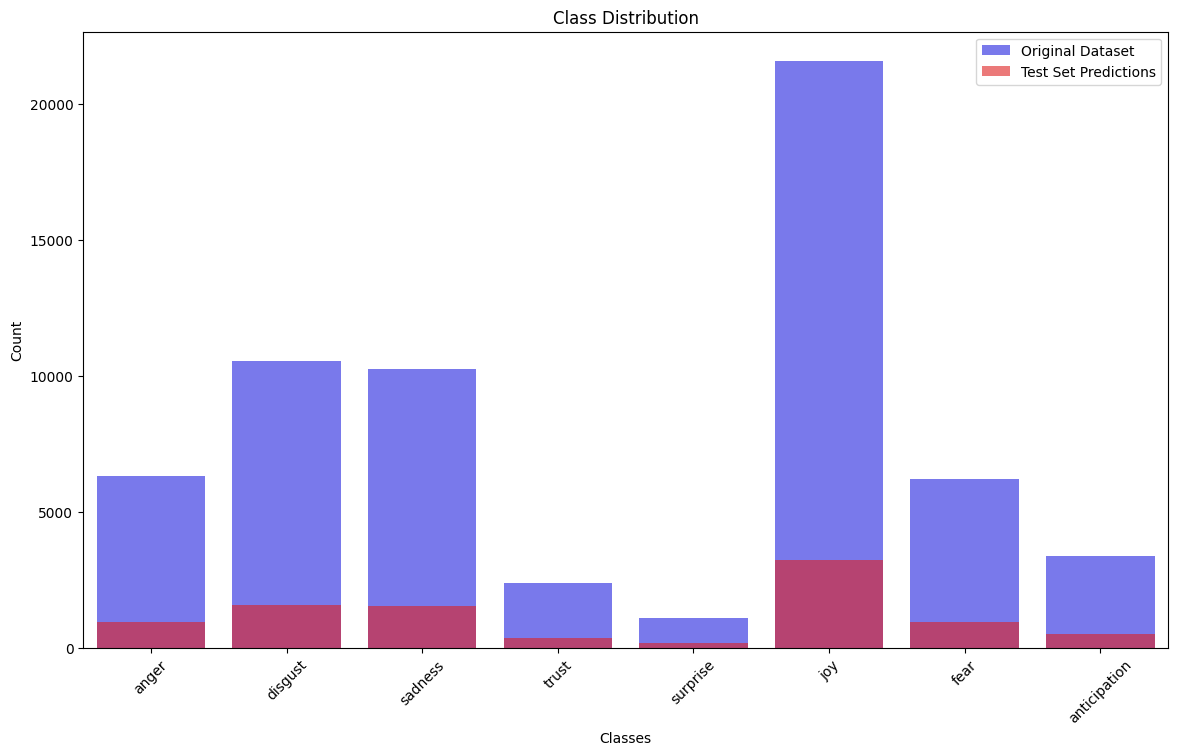

Class-wise Performance Metrics:
anger: F1 Score=0.41, Precision=0.56, Recall=0.32
disgust: F1 Score=0.64, Precision=0.64, Recall=0.65
sadness: F1 Score=0.61, Precision=0.66, Recall=0.56
trust: F1 Score=0.50, Precision=0.48, Recall=0.53
surprise: F1 Score=0.34, Precision=0.42, Recall=0.28
joy: F1 Score=0.73, Precision=0.67, Recall=0.79
fear: F1 Score=0.51, Precision=0.50, Recall=0.53
anticipation: F1 Score=0.49, Precision=0.47, Recall=0.50
Cohen's Kappa Score: 0.51
Top-1 Accuracy: 0.62
Top-2 Accuracy: 0.80
Top-3 Accuracy: 0.89


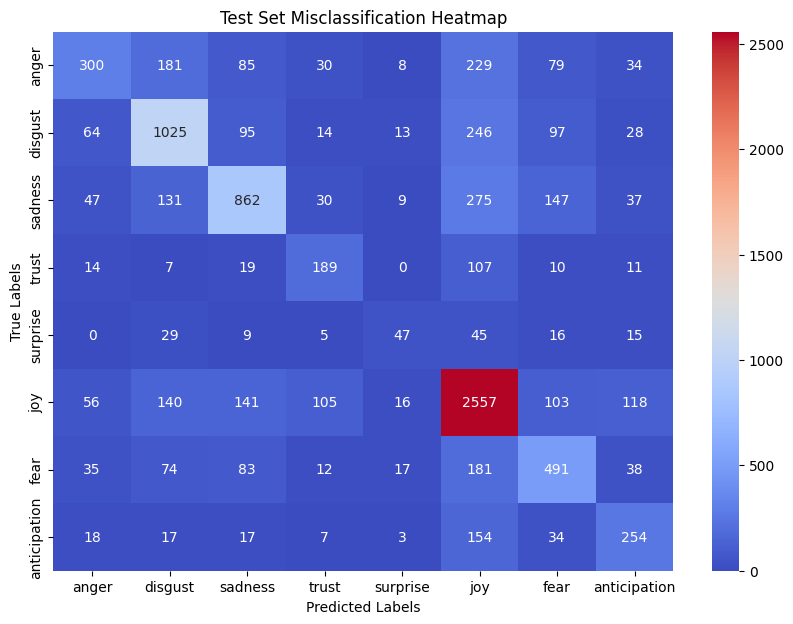

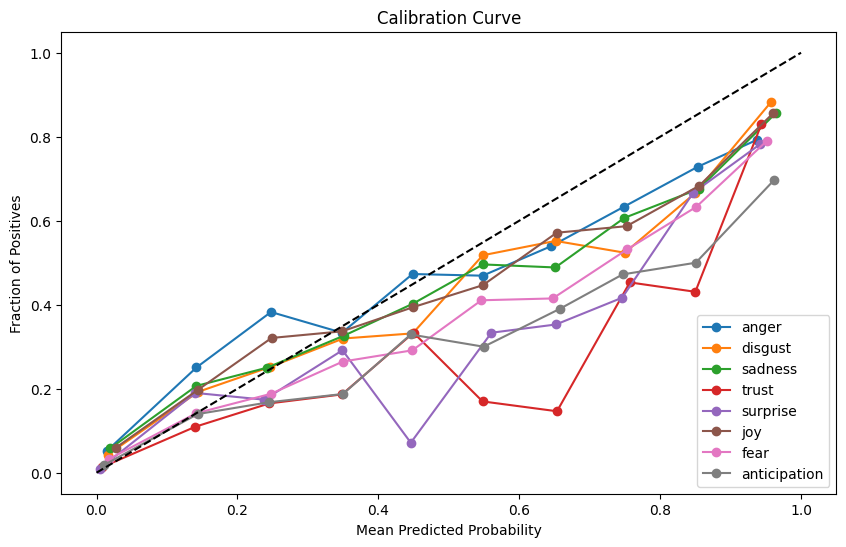

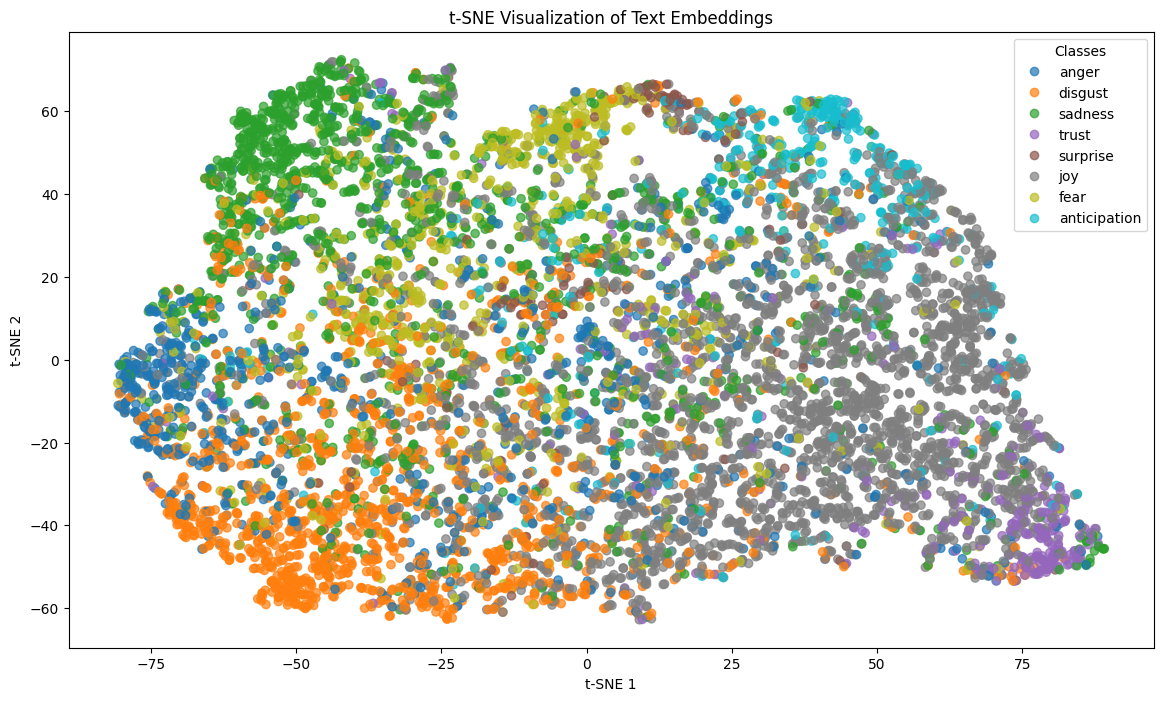

In [16]:
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def additional_evaluations(loader, set_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_logits = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_predictions.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

    all_logits = np.array(all_logits)
    all_probabilities = softmax(all_logits, axis=1)
    all_true_labels = np.array(all_true_labels)
    all_predictions = np.array(all_predictions)

    # Class distribution analysis
    plt.figure(figsize=(14, 8))
    sns.countplot(x=df['plutchik_emotion'], color='blue', alpha=0.6, label='Original Dataset')
    sns.countplot(x=[list(label_dict.keys())[label] for label in all_true_labels], color='red', alpha=0.6, label='Test Set Predictions')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    # Class-wise performance metrics
    print("Class-wise Performance Metrics:")
    for i, emotion in enumerate(label_dict.keys()):
        f1 = f1_score(all_true_labels, all_predictions, labels=[i], average='macro')
        precision = precision_score(all_true_labels, all_predictions, labels=[i], average='macro')
        recall = recall_score(all_true_labels, all_predictions, labels=[i], average='macro')
        print(f"{emotion}: F1 Score={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}")

    # Cohen's Kappa Score
    kappa = cohen_kappa_score(all_true_labels, all_predictions)
    print(f"Cohen's Kappa Score: {kappa:.2f}")

    # Top-K Accuracy
    top_k_accuracies = []
    k_values = [1, 2, 3]
    for k in k_values:
        top_k_preds = np.argsort(all_logits, axis=1)[:, -k:]
        top_k_accuracy = np.mean([1 if all_true_labels[i] in top_k_preds[i] else 0 for i in range(len(all_true_labels))])
        top_k_accuracies.append(top_k_accuracy)
        print(f"Top-{k} Accuracy: {top_k_accuracy:.2f}")

    # Misclassification heatmap
    misclass_matrix = confusion_matrix(all_true_labels, all_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(misclass_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    plt.title(f'{set_name} Set Misclassification Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Calibration Curve
    from sklearn.calibration import calibration_curve
    plt.figure(figsize=(10, 6))
    for i in range(len(label_dict)):
        prob_true, prob_pred = calibration_curve([1 if label == i else 0 for label in all_true_labels], all_probabilities[:, i], n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=f'{list(label_dict.keys())[i]}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Embedding visualization (t-SNE)
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE_INT)
    embeddings = tsne.fit_transform(all_logits)

    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=all_true_labels, cmap='tab10', alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=label_dict.keys(), title='Classes')
    plt.title('t-SNE Visualization of Text Embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

additional_evaluations(test_loader, "Test")

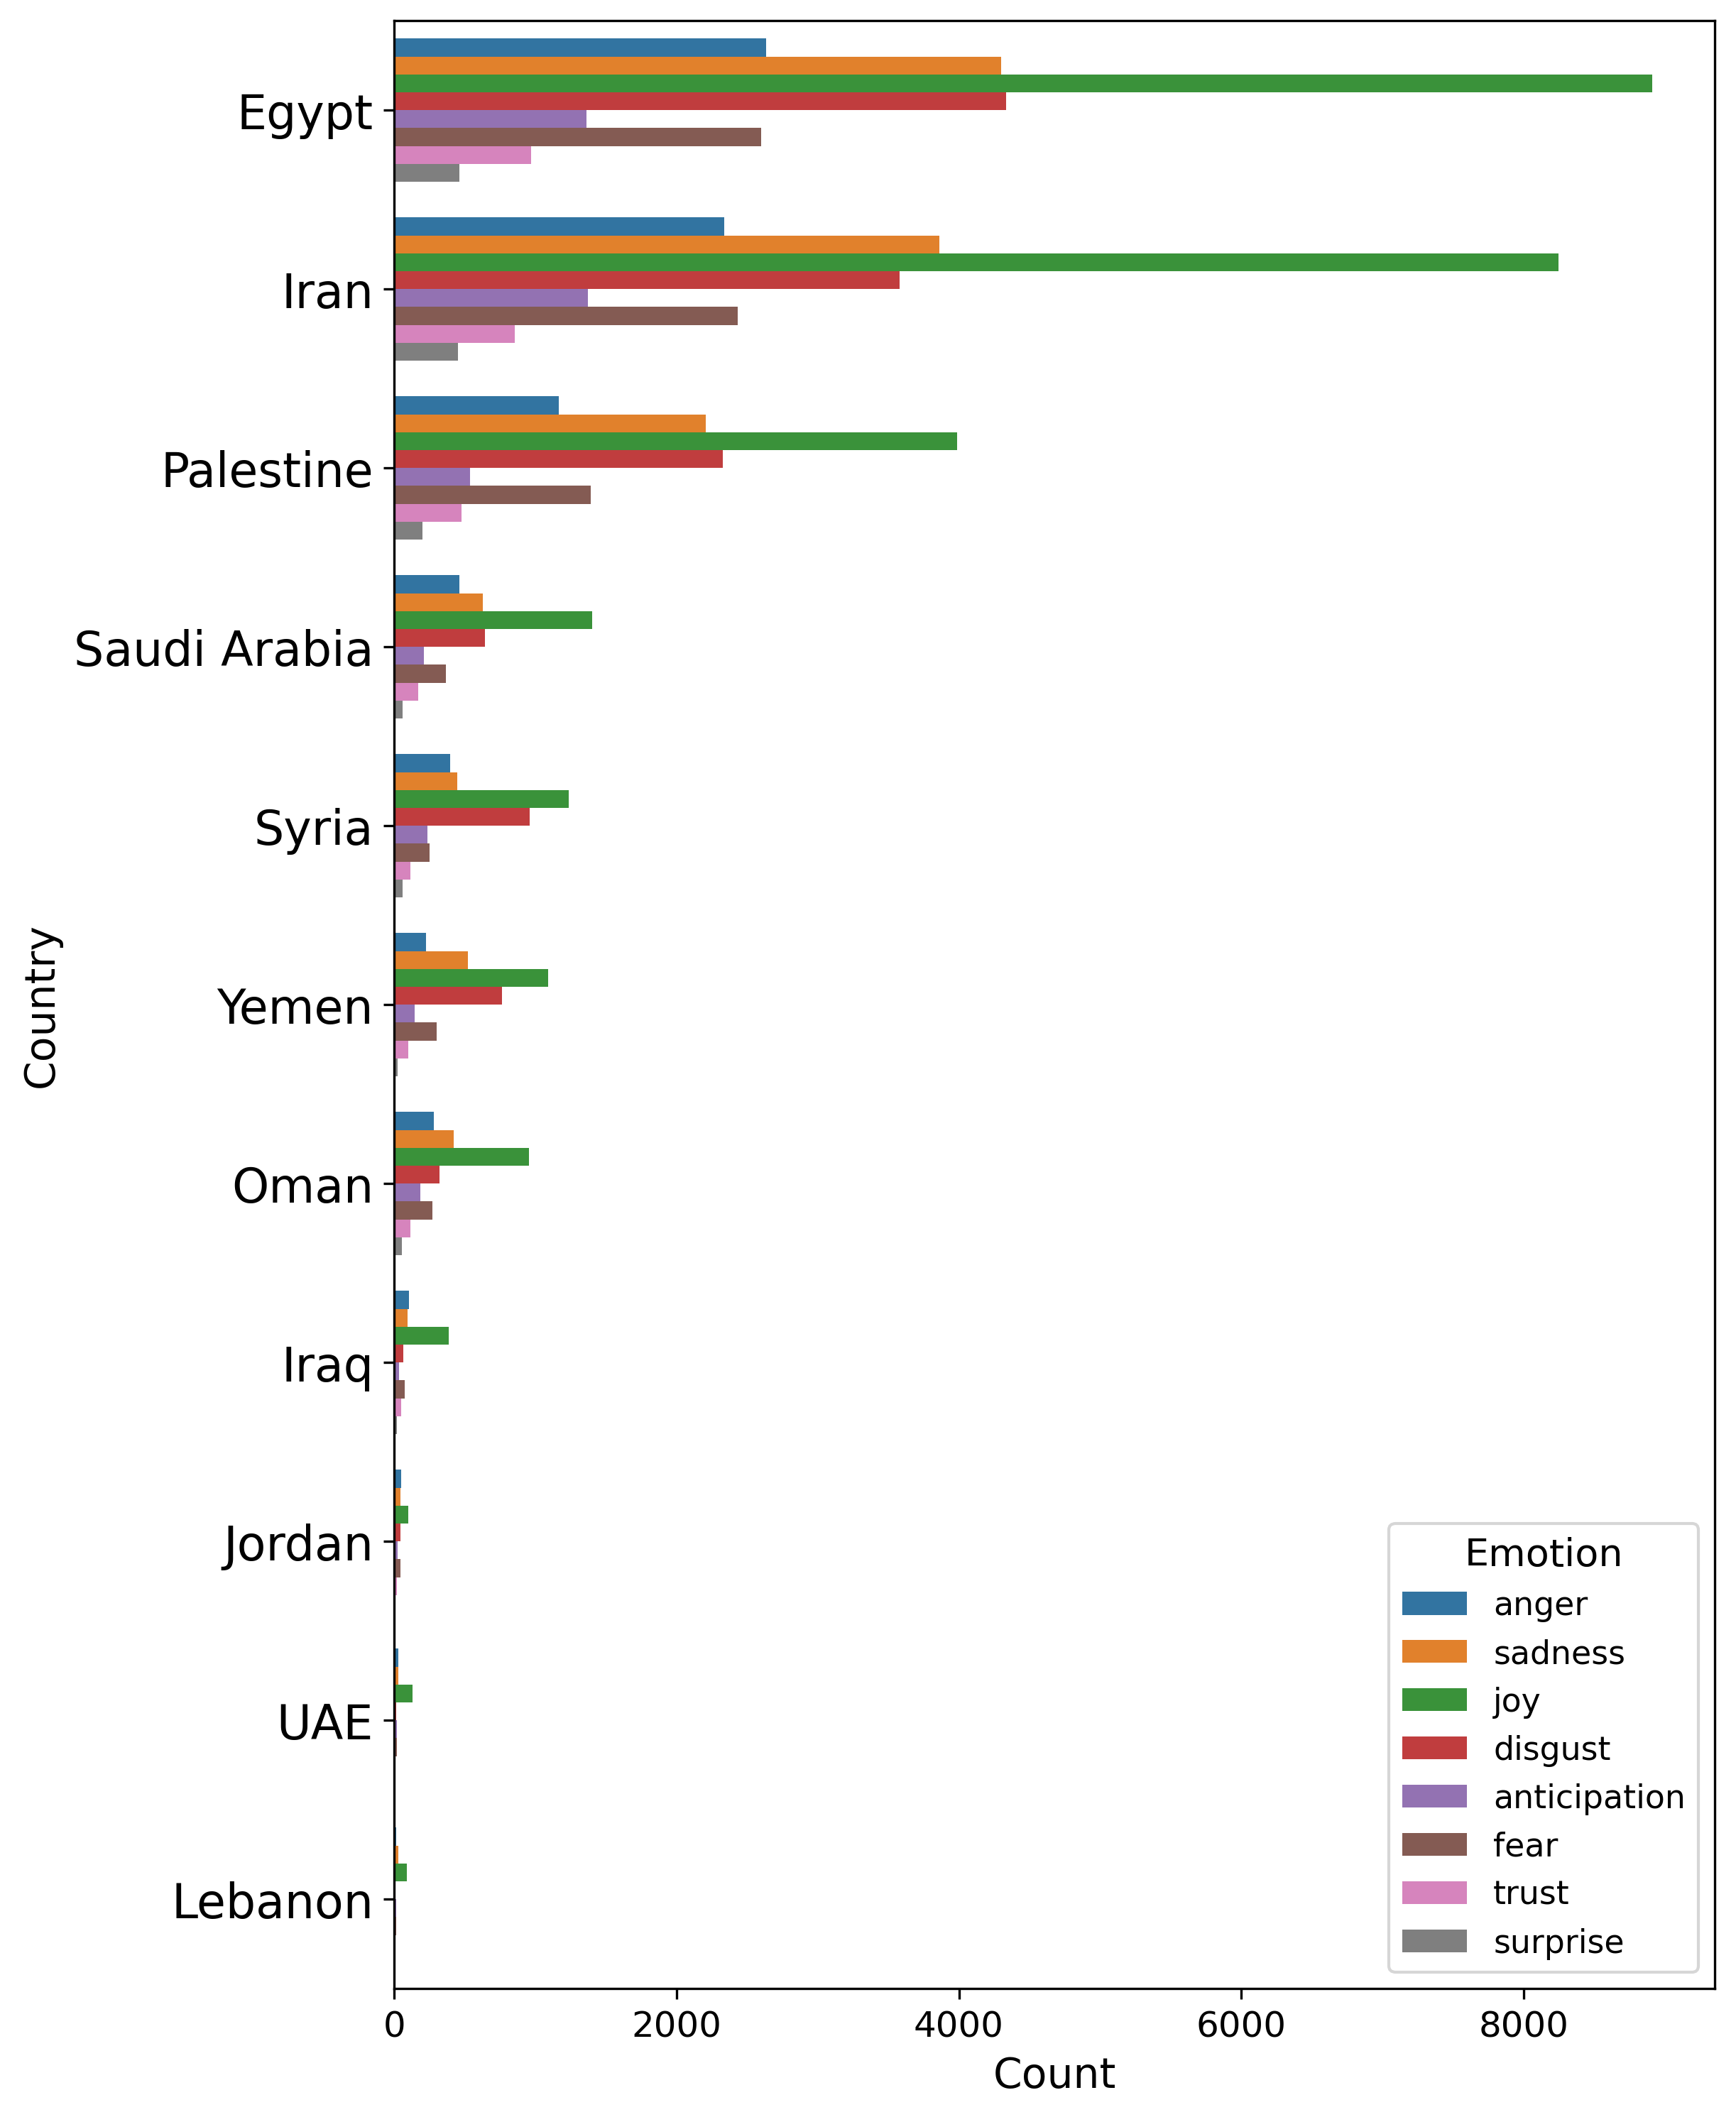

Misclassifications by Country:
                      Misclassifications
Egypt                               1846
Iran                                1028
Palestine                            480
Yemen                                249
Syria                                174
Saudi Arabia                         160
Oman                                 134
Iraq                                  35
Jordan                                16
United Arab Emirates                  10
Lebanon                                2


In [17]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from collections import Counter

# Step 1: Emotions by Country
def emotions_by_country(df):
    country_emotion_dict = {}

    for index, row in df.iterrows():
        countries = eval(row['country_names'])
        emotion = row['plutchik_emotion']
        for country in countries:
            if country not in country_emotion_dict:
                country_emotion_dict[country] = []
            country_emotion_dict[country].append(emotion)

    country_emotion_counts = {country: Counter(emotions) for country, emotions in country_emotion_dict.items()}
    country_emotion_df = pd.DataFrame.from_dict(country_emotion_counts, orient='index').fillna(0)
    return country_emotion_df

# Step 2: Bar Chart of Emotions by Country
def plot_emotions_by_country(df):
    country_emotion_df = emotions_by_country(df)
    country_emotion_df['Total'] = country_emotion_df.sum(axis=1)
    sorted_df = country_emotion_df.sort_values(by='Total', ascending=False).drop(columns='Total')
    # Replace 'United Arab Emirates' with 'UAE' so the graph looks a bit smaller for the paper
    sorted_df.rename(index={'United Arab Emirates': 'UAE'}, inplace=True)
    melted_df = sorted_df.reset_index().melt(id_vars='index', var_name='Emotion', value_name='Count')
    melted_df = melted_df[melted_df['Count'] > 0]

    plt.figure(figsize=(8, 12), dpi=300)
    sns.barplot(data=melted_df, y='index', x='Count', hue='Emotion')
    plt.ylabel('Country', fontsize=14)
    plt.xlabel('Count', fontsize=14)
    plt.yticks(rotation=0, fontsize=16)
    plt.xticks(fontsize=12)
    plt.legend(title='Emotion', title_fontsize='13', fontsize='11')
    plt.show()

# Step 3: Distribution of Misclassified Examples by Country
def misclassifications_by_country(df, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    misclassified_examples = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            preds = torch.argmax(outputs.logits, dim=-1)

            for i, (pred, label) in enumerate(zip(preds, labels)):
                if pred != label:
                    flattened_input_ids = input_ids.view(-1).cpu().numpy()
                    countries = eval(df.iloc[flattened_input_ids[i]]['country_names'])
                    misclassified_examples.append({
                        'text': df.iloc[flattened_input_ids[i]]['excerpt_value_cleaned'],
                        'true_label': label.item(),
                        'predicted_label': pred.item(),
                        'countries': countries
                    })

    country_misclassifications = Counter([country for example in misclassified_examples for country in example['countries']])
    country_misclass_df = pd.DataFrame.from_dict(country_misclassifications, orient='index', columns=['Misclassifications']).sort_values(by='Misclassifications', ascending=False)

    return country_misclass_df

country_emotion_df = emotions_by_country(df)
plot_emotions_by_country(df)
misclassifications_df = misclassifications_by_country(df, test_loader)
print("Misclassifications by Country:")
print(misclassifications_df)


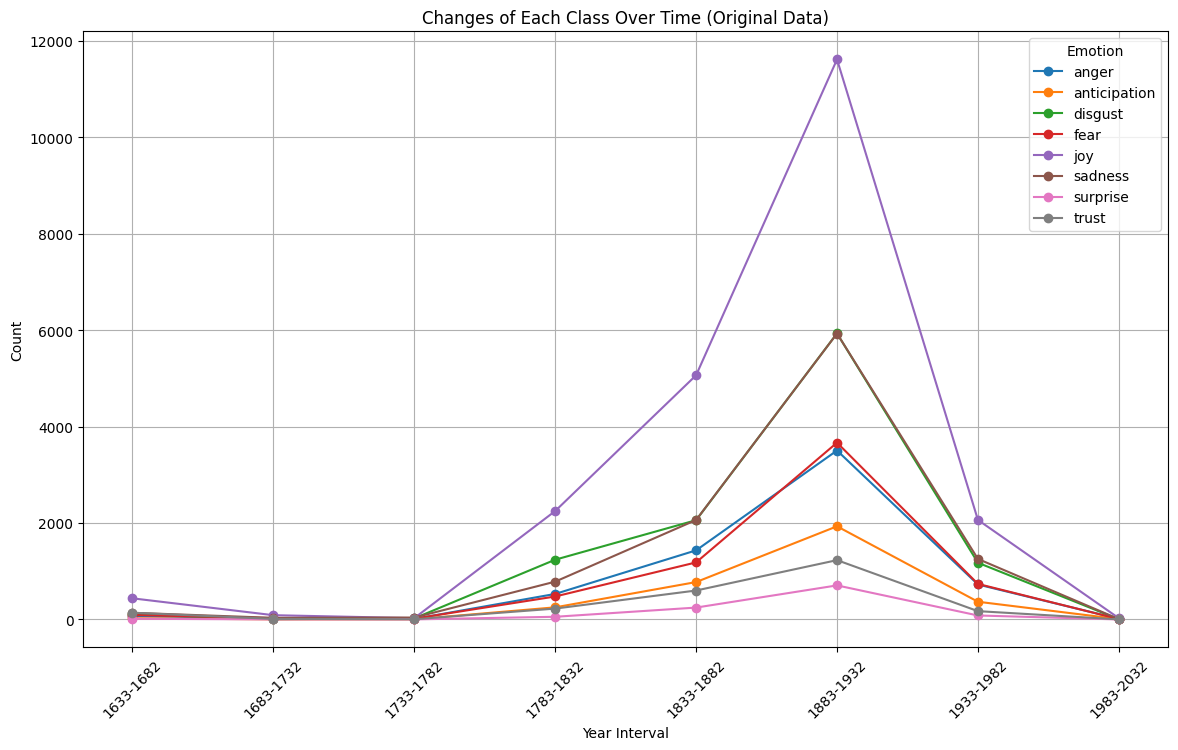

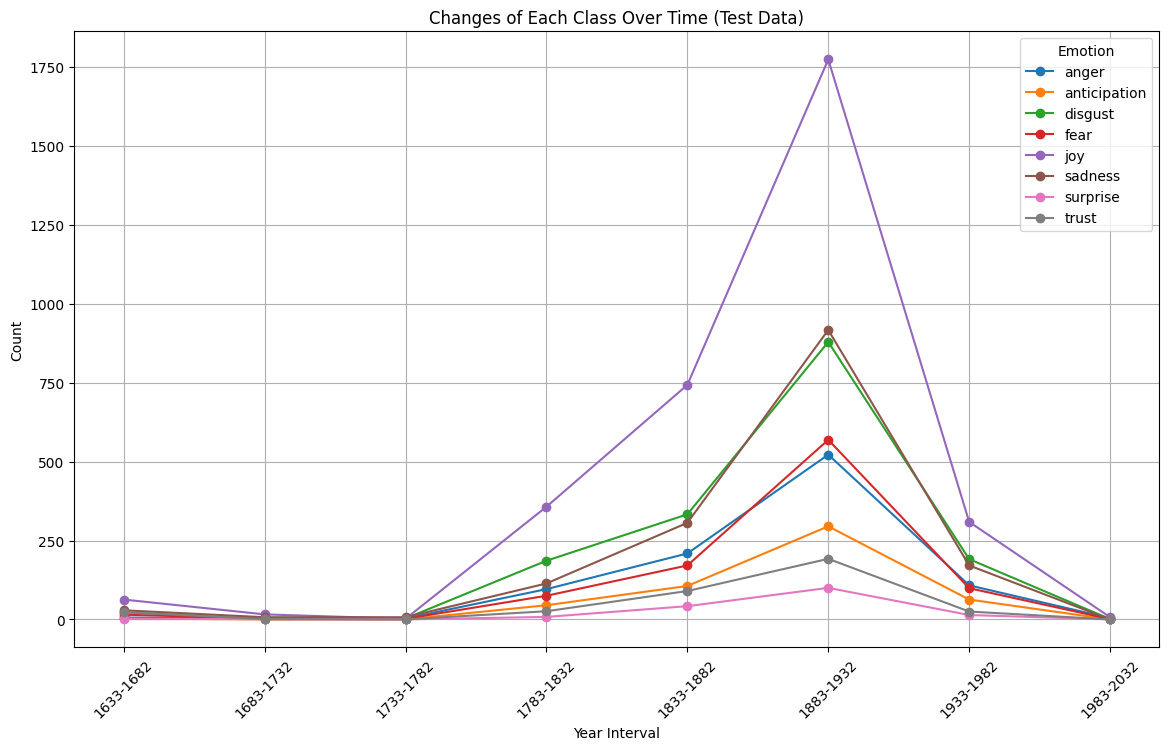

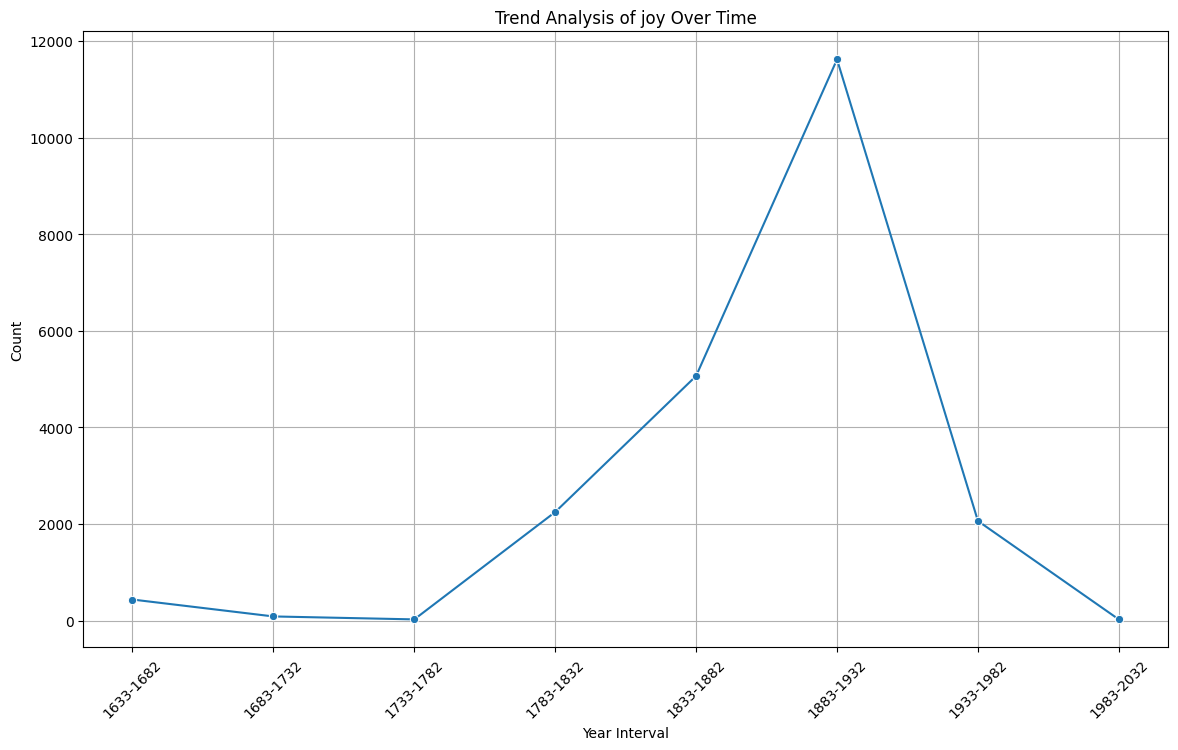

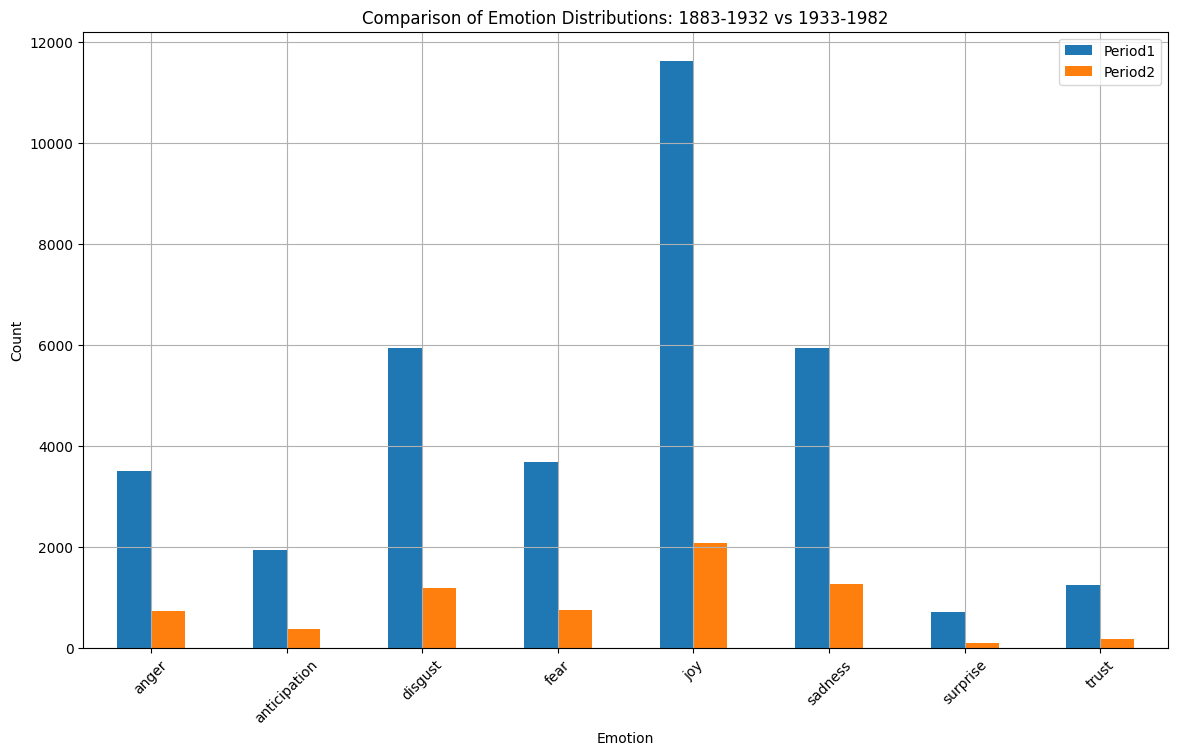

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Reconstruct the test DataFrame
test_df = pd.DataFrame({
    'excerpt_value_cleaned': test_texts,
    'emotion_labels': test_labels
})

# Merge with the original DataFrame to get metadata
test_df = test_df.merge(df[['excerpt_value_cleaned', 'source_date', 'plutchik_emotion']], on='excerpt_value_cleaned', how='left')

# Step 1: Group Data by 50-Year Intervals
def group_by_intervals(df, interval=50):
    df['source_date'] = df['source_date'].astype(int)
    min_year = df['source_date'].min()
    max_year = df['source_date'].max()
    bins = list(range(min_year, max_year + interval, interval))
    labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]
    df['year_interval'] = pd.cut(df['source_date'], bins=bins, labels=labels, right=False)
    return df

# Step 2: Count Occurrences of Each Emotion in Each Interval
def count_emotions_by_intervals(df):
    interval_emotion_counts = df.groupby(['year_interval', 'plutchik_emotion']).size().unstack(fill_value=0)
    return interval_emotion_counts

# Step 3: Line Graph of Class Changes Over Time
def plot_class_changes_over_time(interval_emotion_counts, title):
    interval_emotion_counts.plot(kind='line', figsize=(14, 8), marker='o')
    plt.title(title)
    plt.xlabel('Year Interval')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Emotion')
    plt.grid(True)
    plt.show()

df = group_by_intervals(df)
test_df = group_by_intervals(test_df)

interval_emotion_counts = count_emotions_by_intervals(df)
test_interval_emotion_counts = count_emotions_by_intervals(test_df)

plot_class_changes_over_time(interval_emotion_counts, 'Changes of Each Class Over Time (Original Data)')
plot_class_changes_over_time(test_interval_emotion_counts, 'Changes of Each Class Over Time (Test Data)')

# Additional Analysis Ideas

# Trend Analysis: Identify trends for specific emotions over time
def plot_trend_analysis(interval_emotion_counts, emotion):
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=interval_emotion_counts[emotion], marker='o')
    plt.title(f'Trend Analysis of {emotion} Over Time')
    plt.xlabel('Year Interval')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

plot_trend_analysis(interval_emotion_counts, 'joy')

# Comparative Analysis: Compare emotion distributions between different time periods
def compare_emotion_distributions(df, period1, period2):
    period1_counts = df[df['year_interval'] == period1]['plutchik_emotion'].value_counts()
    period2_counts = df[df['year_interval'] == period2]['plutchik_emotion'].value_counts()

    comparison_df = pd.DataFrame({'Period1': period1_counts, 'Period2': period2_counts}).fillna(0)
    comparison_df.plot(kind='bar', figsize=(14, 8))
    plt.title(f'Comparison of Emotion Distributions: {period1} vs {period2}')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example: Compare distributions between two specific periods
compare_emotion_distributions(df, '1883-1932', '1933-1982')


In [19]:
# Check available intervals in the original dataset
print("Available intervals in the original dataset:", df['year_interval'].unique())

# Check available intervals in the test dataset
print("Available intervals in the test dataset:", test_df['year_interval'].unique())


Available intervals in the original dataset: ['1883-1932', '1833-1882', '1783-1832', '1933-1982', '1983-2032', '1633-1682', '1683-1732', '1733-1782']
Categories (8, object): ['1633-1682' < '1683-1732' < '1733-1782' < '1783-1832' < '1833-1882' <
                         '1883-1932' < '1933-1982' < '1983-2032']
Available intervals in the test dataset: ['1783-1832', '1883-1932', '1833-1882', '1933-1982', '1633-1682', '1683-1732', '1983-2032', '1733-1782']
Categories (8, object): ['1633-1682' < '1683-1732' < '1733-1782' < '1783-1832' < '1833-1882' <
                         '1883-1932' < '1933-1982' < '1983-2032']


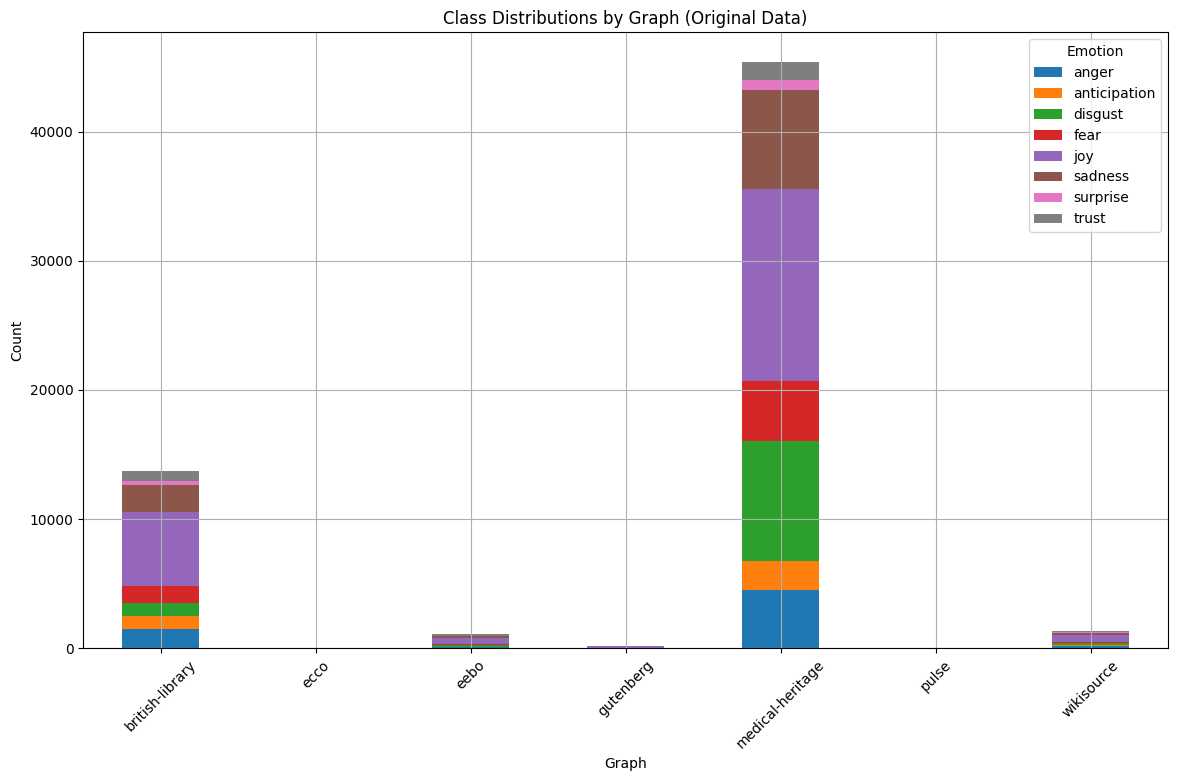

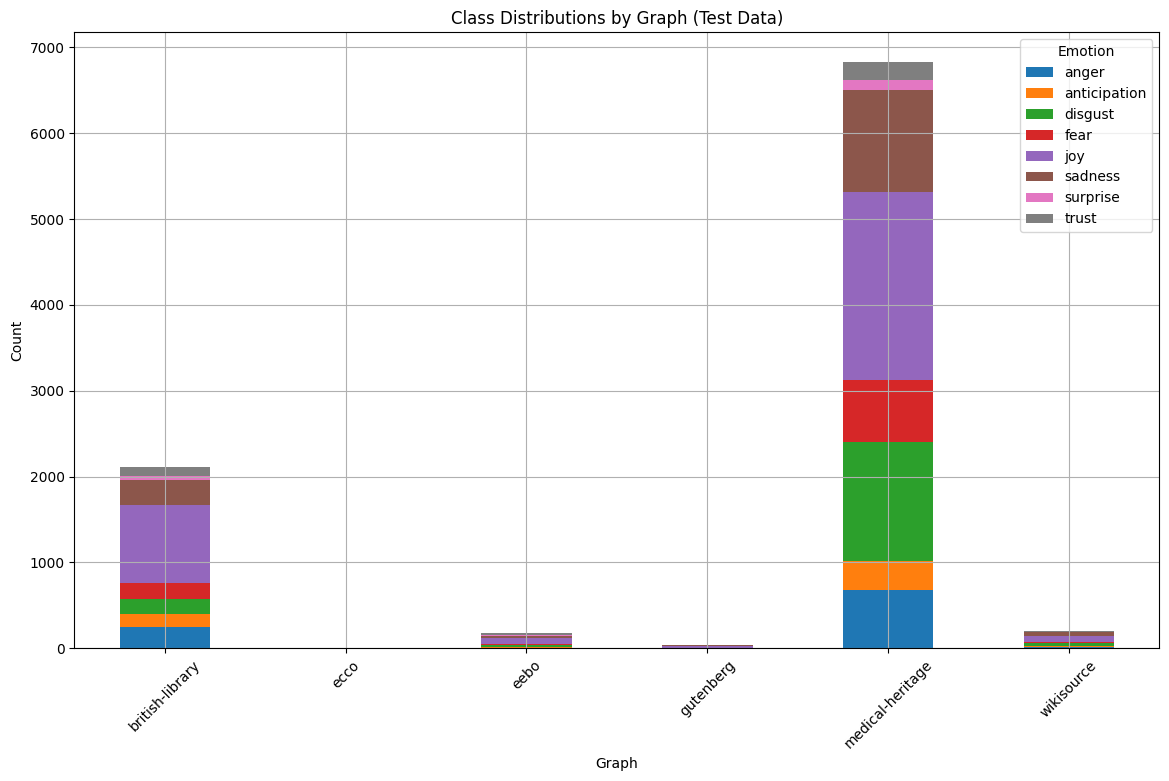

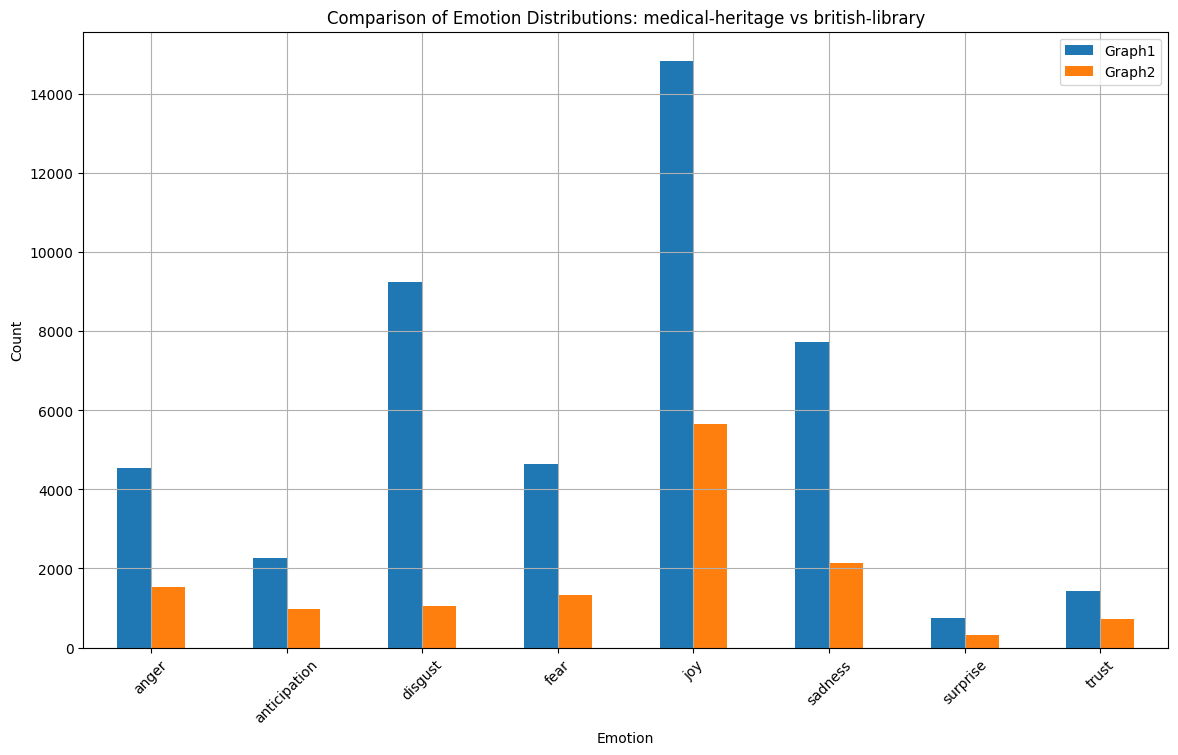

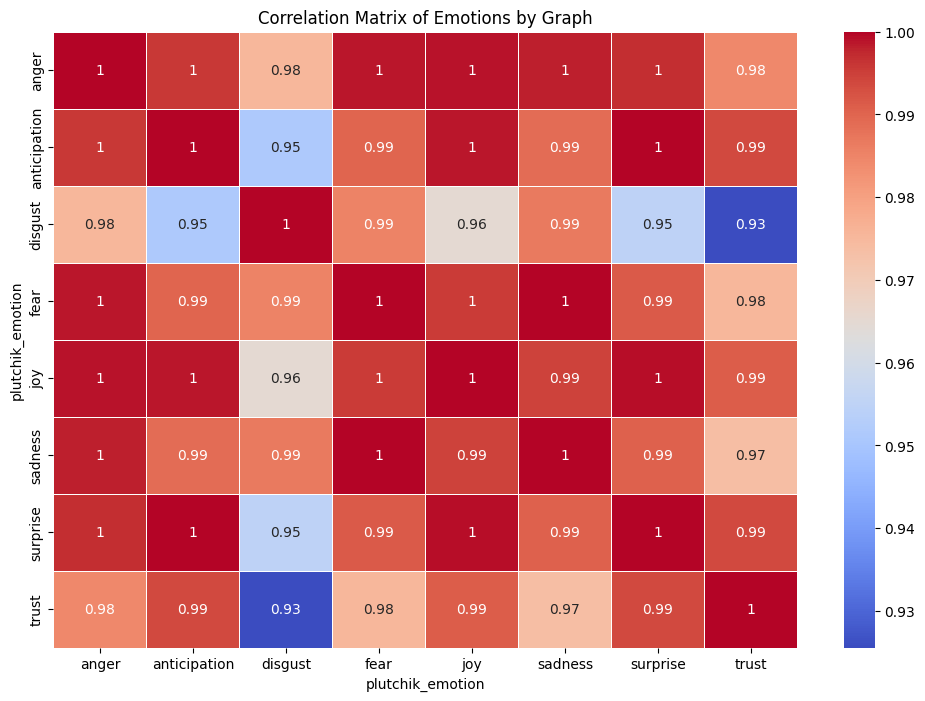

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency


test_df = pd.DataFrame({
    'excerpt_value_cleaned': test_texts,
    'emotion_labels': test_labels
})

test_df = test_df.merge(df[['excerpt_value_cleaned', 'source_date', 'plutchik_emotion', 'graph']], on='excerpt_value_cleaned', how='left')

# Step 1: Class Distributions by Graph
def class_distributions_by_graph(df):
    graph_emotion_counts = df.groupby(['graph', 'plutchik_emotion']).size().unstack(fill_value=0)
    return graph_emotion_counts

# Step 2: Plot Class Distributions by Graph
def plot_class_distributions_by_graph(graph_emotion_counts, title):
    graph_emotion_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.title(title)
    plt.xlabel('Graph')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Emotion')
    plt.grid(True)
    plt.show()

# Analyze and plot for original and test datasets
graph_emotion_counts = class_distributions_by_graph(df)
test_graph_emotion_counts = class_distributions_by_graph(test_df)

plot_class_distributions_by_graph(graph_emotion_counts, 'Class Distributions by Graph (Original Data)')
plot_class_distributions_by_graph(test_graph_emotion_counts, 'Class Distributions by Graph (Test Data)')


# Comparative Analysis: Compare emotion distributions between different sources
def compare_emotion_distributions_by_graph(df, graph1, graph2):
    graph1_counts = df[df['graph'] == graph1]['plutchik_emotion'].value_counts()
    graph2_counts = df[df['graph'] == graph2]['plutchik_emotion'].value_counts()

    comparison_df = pd.DataFrame({'Graph1': graph1_counts, 'Graph2': graph2_counts}).fillna(0)
    comparison_df.plot(kind='bar', figsize=(14, 8))
    plt.title(f'Comparison of Emotion Distributions: {graph1} vs {graph2}')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example: Compare distributions between two specific sources
compare_emotion_distributions_by_graph(df, 'medical-heritage', 'british-library')

# Correlation Analysis: Correlation between source and emotion distributions
def correlation_analysis(df):
    graph_emotion_counts = class_distributions_by_graph(df)
    correlation_matrix = graph_emotion_counts.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Matrix of Emotions by Graph')
    plt.show()

# Perform Correlation Analysis
correlation_analysis(df)


In [22]:
import pandas as pd
import json
import re

def clean_json_column(df, column_name):
    cleaned_column = []
    for item in df[column_name]:
        if pd.isna(item):
            cleaned_column.append([])
        else:
            try:
                # Replace single quotes with double quotes, carefully handling escape characters
                item = re.sub(r"\\'", "'", item)
                item = item.replace("'", "\"")
                item = item.replace("None", "null")
                json_data = json.loads(item)
                labels = [entry['label'] for entry in json_data if 'label' in entry and entry['label']]
                cleaned_column.append(labels)
            except (json.JSONDecodeError, KeyError, TypeError) as e:
                print(f"Error parsing JSON for item: {item} - {e}")
                cleaned_column.append([])
    return cleaned_column


# Clean and preprocess `smellSource` and `carrier`
df['cleaned_smellSource'] = clean_json_column(df, 'smellSource')
df['cleaned_carrier'] = clean_json_column(df, 'carrier')

print(df[['smellSource', 'cleaned_smellSource', 'carrier', 'cleaned_carrier']])


Error parsing JSON for item: [{"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/113", "label": "Peau d"Espagne"}, {"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/172", "label": "Patchouli"}] - Expecting ',' delimiter: line 1 column 86 (char 85)
Error parsing JSON for item: [{"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/113", "label": "Peau d"Espagne"}, {"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/172", "label": "Patchouli"}] - Expecting ',' delimiter: line 1 column 86 (char 85)
Error parsing JSON for item: [{"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/113", "label": "Peau d"Espagne"}, {"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/172", "label": "Patchouli"}] - Expecting ',' delimiter: line 1 column 86 (char 85)
Error parsing JSON for item: [{"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/113", "label": "Peau d"Espagne"}, {"id": "http://data.odeuropa.eu/vocabulary/olfactory-objects/172", "

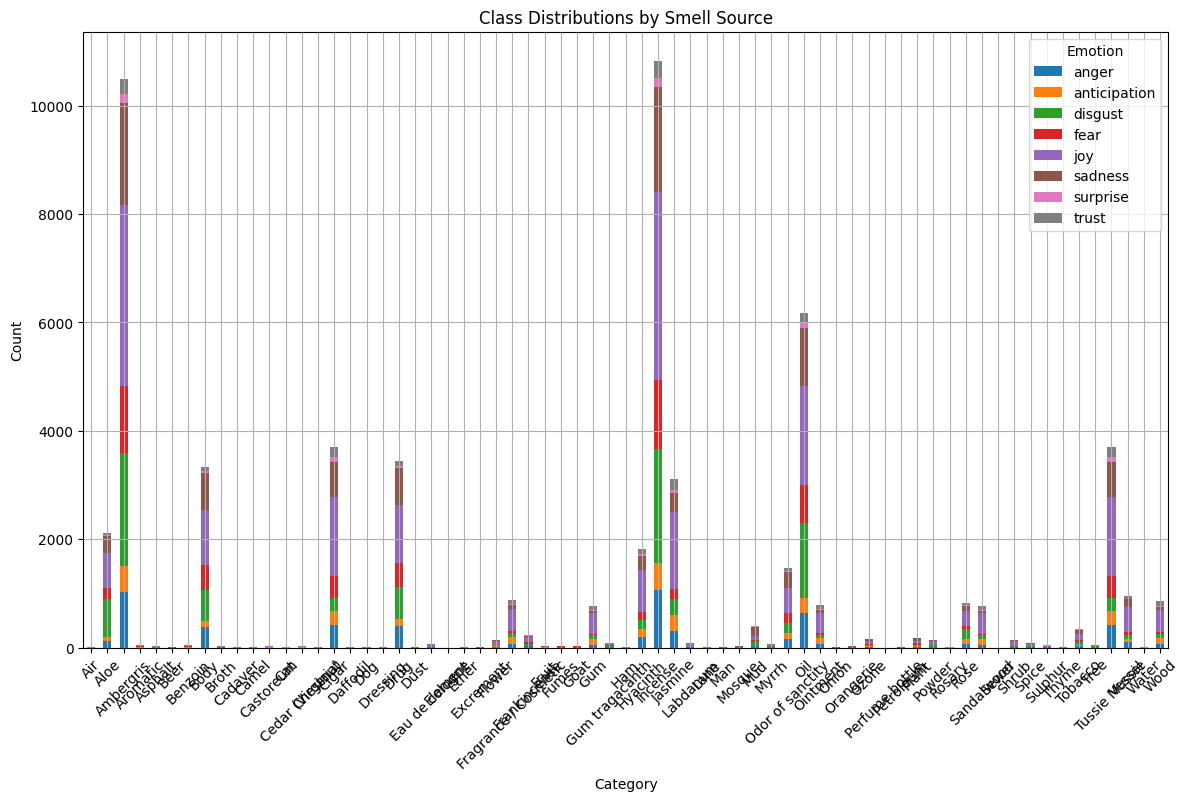

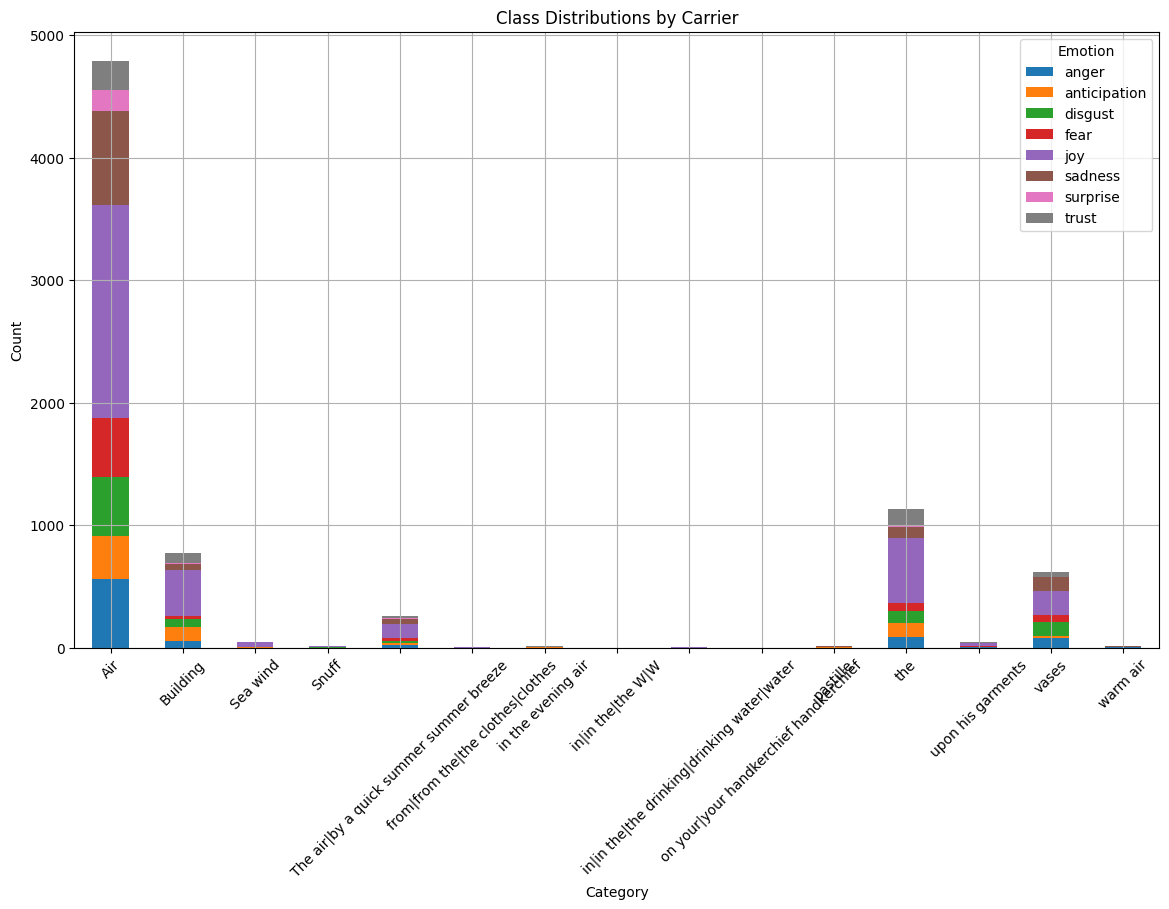

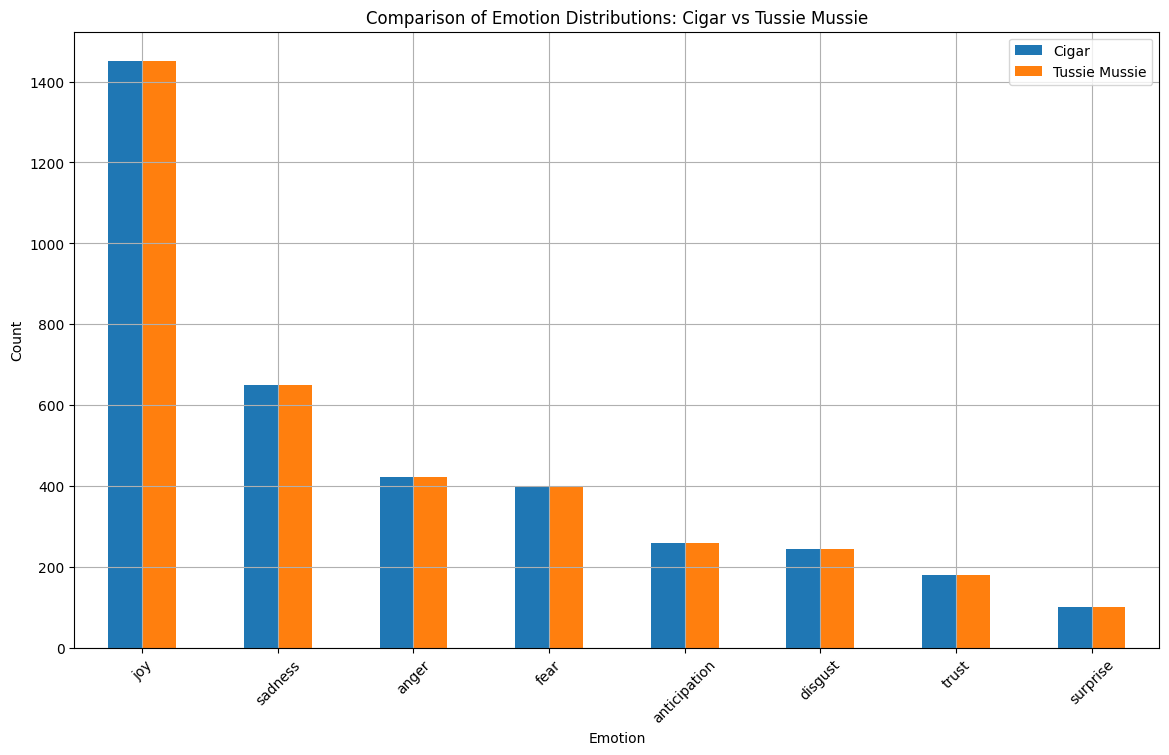

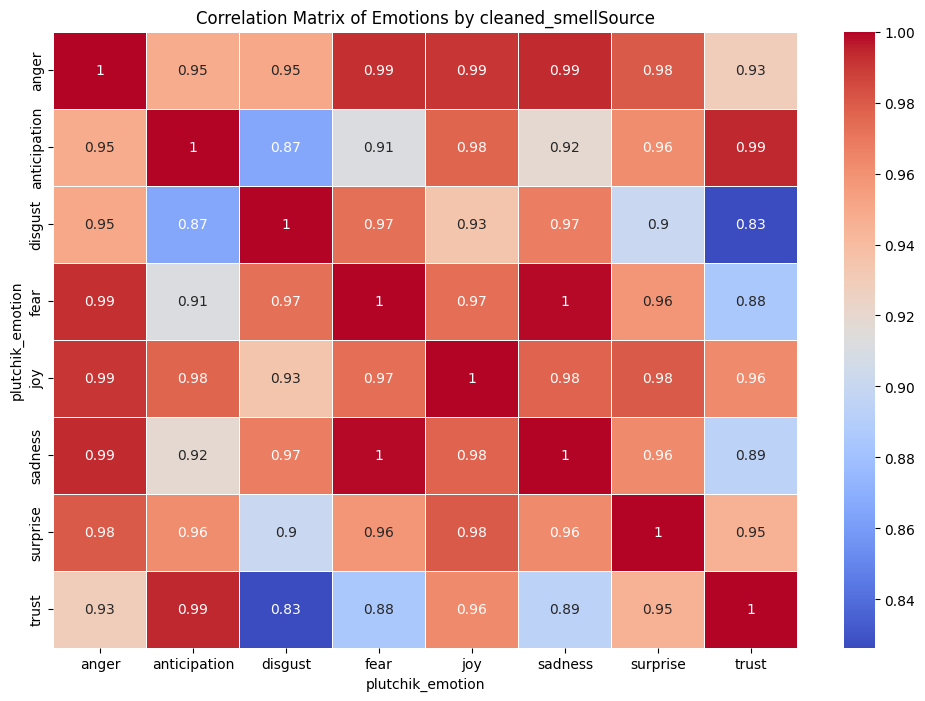

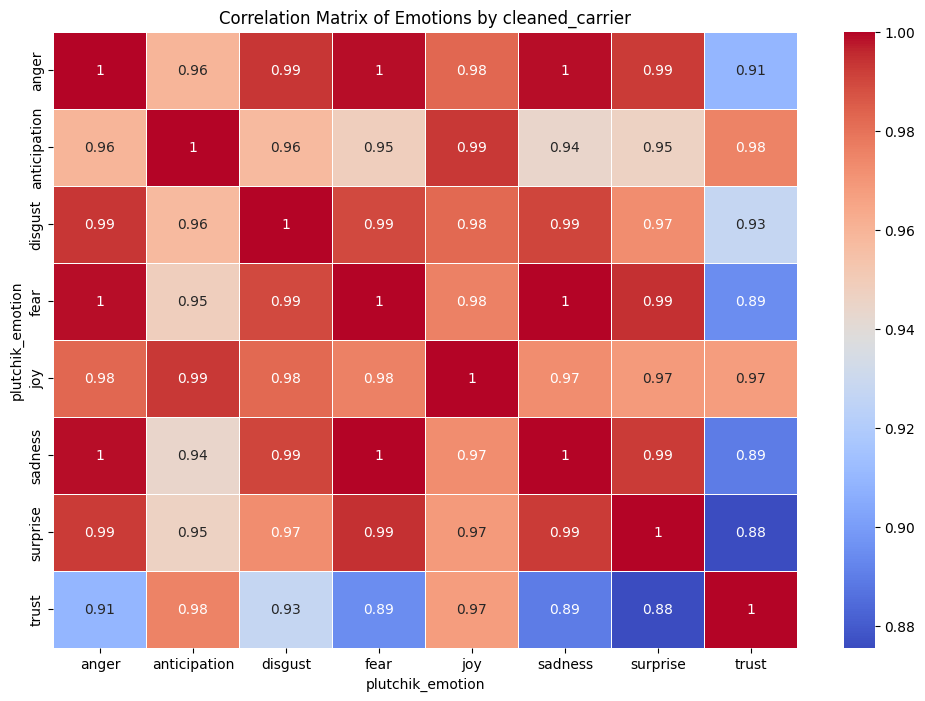

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency

# Function to explode lists into multiple rows for analysis
def explode_list_column(df, column_name):
    return df.explode(column_name).dropna(subset=[column_name])

# Step 1: Distribution of Emotions by Smell Source
def class_distributions_by_smell_source(df):
    df_exploded = explode_list_column(df, 'cleaned_smellSource')
    source_emotion_counts = df_exploded.groupby(['cleaned_smellSource', 'plutchik_emotion']).size().unstack(fill_value=0)
    return source_emotion_counts

# Step 2: Distribution of Emotions by Carrier
def class_distributions_by_carrier(df):
    df_exploded = explode_list_column(df, 'cleaned_carrier')
    carrier_emotion_counts = df_exploded.groupby(['cleaned_carrier', 'plutchik_emotion']).size().unstack(fill_value=0)
    return carrier_emotion_counts

# Plot Class Distributions
def plot_class_distributions(distribution_counts, title):
    distribution_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Emotion')
    plt.grid(True)
    plt.show()

# Perform Analysis and Plot
smell_source_emotion_counts = class_distributions_by_smell_source(df)
carrier_emotion_counts = class_distributions_by_carrier(df)

plot_class_distributions(smell_source_emotion_counts, 'Class Distributions by Smell Source')
plot_class_distributions(carrier_emotion_counts, 'Class Distributions by Carrier')

# Additional Analysis: Comparative Analysis, Statistical Tests, Correlation Analysis
# Comparative Analysis: Compare emotion distributions between different smell sources or carriers
def compare_emotion_distributions(df, column_name, label1, label2):
    df_exploded = explode_list_column(df, column_name)
    label1_counts = df_exploded[df_exploded[column_name] == label1]['plutchik_emotion'].value_counts()
    label2_counts = df_exploded[df_exploded[column_name] == label2]['plutchik_emotion'].value_counts()

    comparison_df = pd.DataFrame({label1: label1_counts, label2: label2_counts}).fillna(0)
    comparison_df.plot(kind='bar', figsize=(14, 8))
    plt.title(f'Comparison of Emotion Distributions: {label1} vs {label2}')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example: Compare distributions between two specific smell sources
compare_emotion_distributions(df, 'cleaned_smellSource', 'Cigar', 'Tussie Mussie')

# Correlation Analysis: Correlation between categories and emotion distributions
def correlation_analysis(df, column_name):
    df_exploded = explode_list_column(df, column_name)
    column_emotion_counts = df_exploded.groupby([column_name, 'plutchik_emotion']).size().unstack(fill_value=0)
    correlation_matrix = column_emotion_counts.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title(f'Correlation Matrix of Emotions by {column_name}')
    plt.show()

# Perform Correlation Analysis
correlation_analysis(df, 'cleaned_smellSource')
correlation_analysis(df, 'cleaned_carrier')
